In [241]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import gridspec
import seaborn as sns
import matplotlib.patches as patches

import anndata as ad
import scanpy as sc
from cyvcf2 import VCF
from pyfaidx import Fasta
from Bio.Seq import reverse_complement
from Bio.Seq import Seq

from scipy.sparse import csr_matrix
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import hypergeom
from scipy import stats
from scipy.sparse import vstack

from ete3 import Tree
import scipy.spatial.distance as ssd
import scipy.cluster.hierarchy as sch
from skbio.tree import nj, upgma, gme, bme, nni, majority_rule
from skbio import TreeNode
from skbio import DistanceMatrix
import dendropy
import baltic as bt
from io import StringIO
import pyranges as pr

import re
import os
from pathlib import Path
from itertools import product, combinations
from collections import Counter
from tqdm import tqdm

In [29]:
pal = {
    'P_0': '#5AAA46',
    'P_1': '#F2B342',
    'P_2': '#C03830',
    'P_3': '#C43E96',
    'P_4': '#825CA6',
    'P_5': '#317EC2'
}

# Concatenate Anndata Objects

ran the above in a job array, here I concatenate the outputs:

In [3]:
# Directory containing your .h5ad files
input_dir = "vcf_chunks"

# Load all AnnData objects
adatas = []
for fname in sorted(os.listdir(input_dir)):
    if fname.endswith(".h5ad"):
        adata = ad.read_h5ad(os.path.join(input_dir, fname))
        adatas.append(adata)

# Concatenate along variables (features) — axis=1 means concatenate columns
adata = ad.concat(adatas, axis=1, join="outer", merge="unique")
del adatas
adata

/home/dmullane/micromamba/envs/default_jupyter/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/dmullane/micromamba/envs/default_jupyter/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/dmullane/micromamba/envs/default_jupyter/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/dmullane/micromamba/envs/default_jupyter/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/dmullane/micromamba/envs/default_jupyt

AnnData object with n_obs × n_vars = 1441 × 102356132
    layers: 'AD', 'DP'

In [4]:
obs = {}
for cell in adata.obs_names.to_list():
    if 'CTGTGAAC' in cell or 'ACATCGTC' in cell or 'TTGGATGC' in cell or 'GTTACGGT' in cell:
        obs[cell]="P_0"
    elif 'TGGTCTCA' in cell or 'TCCAGGAT' in cell or 'CATACCGT' in cell or 'TTCCACTC' in cell:
        obs[cell]="P_1"
    elif 'GTGACTCT' in cell or 'GGCATCAA' in cell or 'AGATACCG' in cell or 'TTGATGGC' in cell:
        obs[cell]="P_2"
    elif 'CGACCTAT' in cell or 'TCCTCAAC' in cell or 'TTGACCAC' in cell or 'GATGGTCT' in cell:
        obs[cell]="P_3"
    elif 'CGGTAAGT' in cell or 'TGACAGTG' in cell or 'CACTGACA' in cell or 'GTCGGTAA' in cell:
        obs[cell]="P_4"
    elif 'GTAACCGA' in cell or 'GTCCGATT' in cell or 'GACAGCAT' in cell or 'CGGTTGAT' in cell:
        obs[cell]="P_5"
obs = pd.DataFrame.from_dict(obs, orient='index', columns=['pop'])
adata.obs = obs
adata.obs

,pop
AAGGCTTGAGGAAACGATGGACTCAGAATGCCAAGGGTCGGTAAA,P_4
AAGGCTTGAGGAAACGATGGACTCAGAATGCCAAGGTGGTCTCAA,P_1
AAGGCTTGAGGAAACGATGGACTCAGACACCAAAGGCGGTTGATA,P_5
AAGGCTTGAGGAAACTGCTCACTCAGAATGCCAAGGGTCGGTAAA,P_4
AAGGCTTGAGGAAACTGCTCACTCTGCTATGGAAGGTCCTCAACA,P_3
...,...
TGTGGTTGAGGATTCGGTAGACTCACAGTAGCAAGGTTGGATGCA,P_0
TGTGGTTGAGGATTCGGTAGACTCCATCGTTGAAGGGTCGGTAAA,P_4
TGTGGTTGAGGATTCGGTAGACTCCGAACTTGAAGGCGGTTGATA,P_5
TGTGGTTGAGGATTGGTAGCACTCTCTGCTTGAAGGGACAGCATA,P_5


### Filter out non-snps

In [5]:
# Convert Index to Series so we can use .str methods
var_series = pd.Series(adata.var_names, index=adata.var_names)

# Split to get REF and ALT alleles
alleles = var_series.str.extract(r'^[^-]+-\d+-([ACGT]+)>([ACGT]+)$', expand=True)
ref = alleles[0]
alt = alleles[1]

# Boolean mask: keep only SNVs (1 bp ref and alt)
is_snp = (ref.str.len() == 1) & (alt.str.len() == 1)

len(is_snp)

102356132

In [6]:
adata = adata[:, is_snp]
adata = adata.copy()
adata

AnnData object with n_obs × n_vars = 1441 × 74153330
    obs: 'pop'
    layers: 'AD', 'DP'

### Compute VAF in Bulk

In [7]:
adata.var['tot_depth_bulk'] = np.ravel(adata.layers['DP'].sum(axis=0))
adata.var['alt_depth_bulk'] = np.ravel(adata.layers['AD'].sum(axis=0))

adata.var['bulk_VAF_raw'] = adata.var['alt_depth_bulk'] / adata.var['tot_depth_bulk'] 
adata.var

,tot_depth_bulk,alt_depth_bulk,bulk_VAF_raw
chr10-10295-T>G,165.0,3.0,0.018182
chr10-10381-A>T,74.0,2.0,0.027027
chr10-10518-A>T,29.0,13.0,0.448276
chr10-10903-C>G,19.0,11.0,0.578947
chr10-10979-G>C,6.0,4.0,0.666667
...,...,...,...
chrY-56887429-T>C,39.0,6.0,0.153846
chrY-56887462-C>A,21.0,16.0,0.761905
chrY-56887490-C>A,8.0,5.0,0.625000
chrY-56887502-G>T,5.0,2.0,0.400000


### Depth Histogram

Text(0, 0.5, 'Count of Sites')

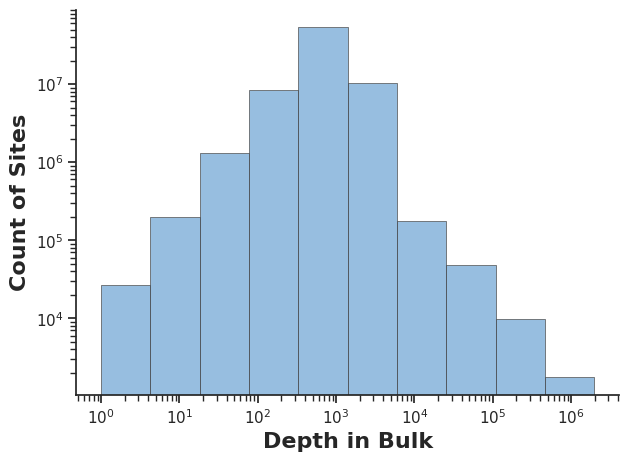

In [8]:
sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)
sns.histplot(adata.var, x='tot_depth_bulk', 
             alpha=0.5,
             color = '#317EC2',
             edgecolor=".3",
             linewidth=.5,
             ax=ax,
             log_scale=True,
             bins=10
            )
ax.set_yscale('log')
plt.xlabel("Depth in Bulk", fontweight='bold', fontsize=16)
plt.ylabel("Count of Sites", fontweight='bold', fontsize=16)

### Bulk VAF Histogram

Text(0, 0.5, 'Count of Sites')

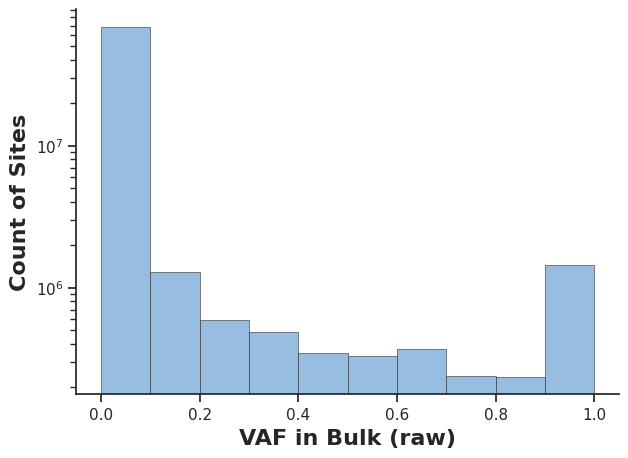

In [9]:
sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)
sns.histplot(adata.var, x='bulk_VAF_raw', 
             alpha=0.5,
             color = '#317EC2',
             edgecolor=".3",
             linewidth=.5,
             ax=ax,
             # log_scale=True,
             bins=10
            )
ax.set_yscale('log')
plt.xlabel("VAF in Bulk (raw)", fontweight='bold', fontsize=16)
plt.ylabel("Count of Sites", fontweight='bold', fontsize=16)

**Compute SNPs per cell**

In [10]:
adata.obs['SNP_count'] = np.ravel(adata.X.sum(axis=1))

In [11]:
adata.obs['SNP_count'].mean()

352862.12

### Filter Out Low Coverage Sites

In [12]:
good_coverage = adata.var['tot_depth_bulk']>=100

In [13]:
adata = adata[:, good_coverage]
adata = adata.copy()
adata

AnnData object with n_obs × n_vars = 1441 × 72002880
    obs: 'pop', 'SNP_count'
    var: 'tot_depth_bulk', 'alt_depth_bulk', 'bulk_VAF_raw'
    layers: 'AD', 'DP'

### Filter Cells with abberantly low or high SNP counts

Text(0, 0.5, 'SNP Count')

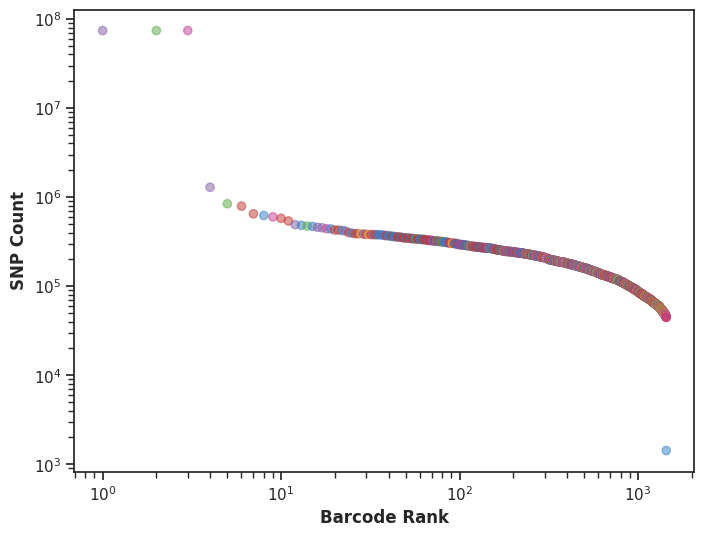

In [14]:
snp_counts = adata.obs.sort_values(by='SNP_count', ascending=False).copy()
colors = snp_counts['pop'].map(pal)

plt.figure(figsize=(8, 6))
plt.scatter(snp_counts.index.to_numpy(), snp_counts['SNP_count'].to_numpy(),
            c=colors,
            alpha=0.5,
            ec=colors
           )
plt.yscale('log')
plt.xscale('log')
# plt.xlim(1,len(snp_counts.index))
plt.xlabel('Barcode Rank', fontdict={'weight':'bold'})
plt.ylabel('SNP Count', fontdict={'weight':'bold'})

In [15]:
selected_barcodes = (
    adata.obs
    .query('SNP_count < 1e6')    # Step 1: filter
    .sort_values(by='SNP_count', ascending=False)  # Step 2: sort
    .head(1000)                  # Step 3: take top 1000
    .index                       # get the barcodes (index)
)
selected_barcodes

Index(['GTGAGACTAGGATGGTCACTACTCAGGACATCAAGGACATCGTCA',
       'CGCTAGTTAGGAGTCTGCTAACTCGGAACTGTAAGGGTGACTCTA',
       'GTAATGCCAGGACGACAAGAACTCACAGTAGCAAGGGTGACTCTA',
       'ACCTCGTAAGGATACAGCAGACTCGGAACTGTAAGGCGGTTGATA',
       'CGGTAGAAAGGAACCTTCAGACTCTCTGCTTGAAGGTTGACCACA',
       'ATACGACCAGGAAACGATGGACTCCGAACTTGAAGGGTGACTCTA',
       'CAACCAACAGGAGTCTGCTAACTCAGAATGCCAAGGGTGACTCTA',
       'CGCTAGTTAGGAAACTGCTCACTCTCTGCTTGAAGGGTCGGTAAA',
       'ACTAACCGAGGAAGATGGTCACTCTCTGGAACAAGGGTCCGATTA',
       'GTAATGCCAGGAAGGCTAACACTCGCAATGACAAGGCTGTGAACA',
       ...
       'GGTCATTGAGGACTGCTCAAACTCGGAACTGTAAGGTTGATGGCA',
       'ATATGCGGAGGACACCTTGAACTCTGCTATGGAAGGCGACCTATA',
       'ATCGACAGAGGAAACTGCTCACTCTCCAGTCTAAGGCGGTTGATA',
       'CGGTAGAAAGGAAAGGTGACACTCTGCTATGGAAGGTTGGATGCA',
       'CGGTAGAAAGGATACAGCAGACTCTACAACCGAAGGTGGTCTCAA',
       'TACCACAGAGGACTTCAGCAACTCAGACGAACAAGGAGATACCGA',
       'CGGTAGAAAGGAAACGATGGACTCAGAATGCCAAGGAGATACCGA',
       'GTGAGACTAGGAAACTGCTCACTCCACCA

In [16]:
adata = adata[selected_barcodes].copy()

Text(0, 0.5, 'SNP Count')

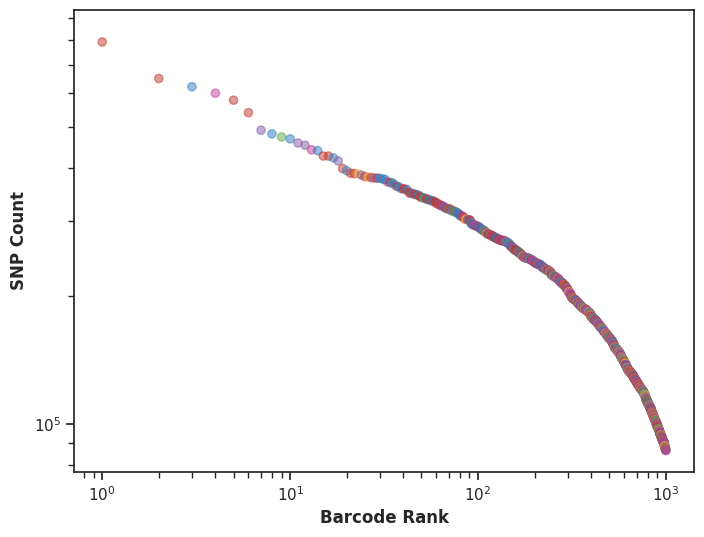

In [17]:
snp_counts = adata.obs.sort_values(by='SNP_count', ascending=False).copy()
colors = snp_counts['pop'].map(pal)

plt.figure(figsize=(8, 6))
plt.scatter(snp_counts.index.to_numpy(), snp_counts['SNP_count'].to_numpy(),
            c=colors,
            alpha=0.5,
            ec=colors
           )
plt.yscale('log')
plt.xscale('log')
# plt.xlim(1,len(snp_counts.index))
plt.xlabel('Barcode Rank', fontdict={'weight':'bold'})
plt.ylabel('SNP Count', fontdict={'weight':'bold'})

### SNP Counts

In [18]:
## SNPs per cell
adata.obs['SNP_count'] = np.ravel(adata.X.sum(axis=1))

In [19]:
adata.obs['SNP_count'].mean()

178836.77

In [24]:
## Total observed sites per cell
adata.obs['tot_observed_sites'] = np.ravel((adata.layers['DP']>0).sum(axis=1))

In [25]:
adata.obs['tot_observed_sites'].mean()

4469908.511

### Save adata

In [26]:
adata.write_h5ad("sc_PolE_all_SNPs.h5ad")

In [74]:
adata = sc.read_h5ad("sc_PolE_all_SNPs.h5ad")

### Germline Variant Distribution and Filtering

first, count mitochondrial variants

In [75]:
mito_variants = [v for v in adata.var_names.tolist() if v.startswith('chrM')]

In [76]:
adata.obs['mito_snps'] = np.ravel(adata[:,adata.var_names.isin(mito_variants)].X.sum(axis=1))

**Load K562 reference**

In [77]:
vcf_file = "ENCFF538YDL_hg38.vcf.gz"

vcf = VCF(vcf_file)

# First: load all variants into a list
K562_variants = list(vcf)

# Extract variant names from that
K562_variants = [f"{v.CHROM}-{v.start}-{v.REF}>{v.ALT[0]}" for v in K562_variants]
K562_variants = np.array(K562_variants)

del vcf

In [78]:
K562_set = set(K562_variants)  # ensure it's a set for O(1) lookup


In [79]:
# Convert Index to Series so we can use .str methods
K562_series = pd.Series(K562_variants)

# Split to get REF and ALT alleles
alleles = K562_series.str.extract(r'^[^-]+-\d+-([ACGT]+)>([ACGT]+)$', expand=True)
ref = alleles[0]
alt = alleles[1]

K562_is_snp = (ref.str.len() == 1) & (alt.str.len() == 1)
K562_snps = K562_series[K562_is_snp]

In [80]:
len(K562_snps)

3069185

In [81]:
K562_snps = np.array(K562_snps)

**Plot distribution**

In [82]:
adata.obs['germline_count'] = np.ravel(adata[:,adata.var_names.isin(K562_snps)].X.sum(axis=1))

In [83]:
adata.obs['germline_count'].mean()

103969.3

**Filtering**

In [84]:
non_germline = ~adata.var_names.isin(K562_snps)

In [85]:
adata = adata[:, non_germline]
adata = adata.copy()
adata

AnnData object with n_obs × n_vars = 1000 × 69135415
    obs: 'pop', 'SNP_count', 'tot_observed_sites', 'mito_snps', 'germline_count'
    var: 'tot_depth_bulk', 'alt_depth_bulk', 'bulk_VAF_raw'
    layers: 'AD', 'DP'

In [86]:
74153330-71137553

3015777

In [87]:
adata.obs['SNP_count_de_novo'] = np.ravel(adata.X.sum(axis=1))

In [88]:
adata.obs['SNP_count_de_novo'].mean()

74867.484

### Corrected VAF

In [89]:
def downsample_vaf(ad, dp, target_dp=10):
    ad = ad.astype(int)
    dp = dp.astype(int)
    downsampled_ad = np.where(
        dp > target_dp,
        hypergeom.rvs(dp, ad, target_dp),  # Downsample AD
        ad  # Keep AD as is if DP <= target_dp
    )
    downsampled_dp = np.minimum(dp, target_dp)
    return downsampled_ad / downsampled_dp


In [90]:
adata.var['bulk_VAF_cor'] = downsample_vaf(adata.var['alt_depth_bulk'], adata.var['tot_depth_bulk'], target_dp=100)

Text(0, 0.5, 'Count of Sites')

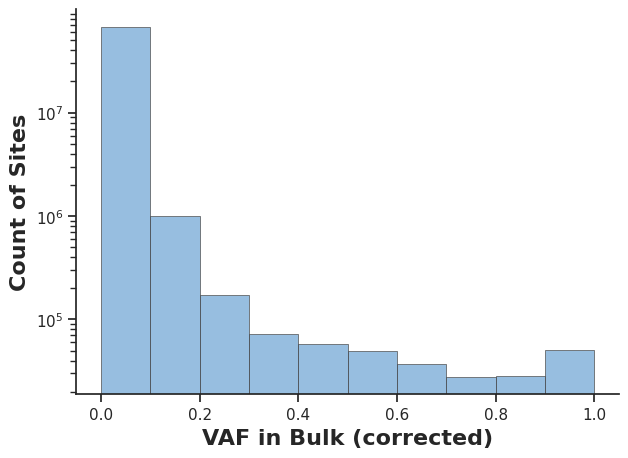

In [91]:
sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)
sns.histplot(adata.var, x='bulk_VAF_cor', 
             alpha=0.5,
             color = '#317EC2',
             edgecolor=".3",
             linewidth=.5,
             ax=ax,
             # log_scale=True,
             bins=10
            )
ax.set_yscale('log')
plt.xlabel("VAF in Bulk (corrected)", fontweight='bold', fontsize=16)
plt.ylabel("Count of Sites", fontweight='bold', fontsize=16)

# Trinucleotide Context

In [13]:
def strand_standardize_trinuc(ref_trinuc, alt_base):
    """If reference is a purine (A/G), reverse complement both trinuc and alt."""
    if ref_trinuc[1] in 'AG':  # purine ref
        trinuc_rc = reverse_complement(ref_trinuc)
        alt_rc = reverse_complement(alt_base)
        return f"{trinuc_rc}>{trinuc_rc[0]}{alt_rc}{trinuc_rc[2]}"
    else:
        return f"{ref_trinuc}>{ref_trinuc[0]}{alt_base}{ref_trinuc[2]}"

In [28]:
def add_trinuc_context(adata, fasta_path):
    # Load reference genome
    ref = Fasta(fasta_path, sequence_always_upper=True)
    
    trinuc_contexts = []

    for variant in tqdm(adata.var_names, total=len(adata.var_names), desc="Getting standardized trinucleotide contexts"):
        # Parse variant
        match = re.match(r'(chr[\w]+)-(\d+)-([ACGT])>([ACGT])', variant)

        chrom, pos, ref_base, alt_base = match.groups()
        pos = int(pos)

        trinuc = ref[chrom][pos - 1 : pos + 2].seq  # [pos-1, pos, pos+1]

        trinuc_context = strand_standardize_trinuc(trinuc, alt_base)
        trinuc_contexts.append(trinuc_context)

    adata.var["context"] = pd.Categorical(trinuc_contexts)
    return adata

In [16]:
fasta = '/shared/biodata/reference/iGenomes/Homo_sapiens/UCSC/hg38/Sequence/WholeGenomeFasta/genome.fa'

In [29]:
add_trinuc_context(adata, fasta)

Getting standardized trinucleotide contexts: 100%|██████████| 69135415/69135415 [12:16<00:00, 93860.58it/s] 


AnnData object with n_obs × n_vars = 1000 × 69135415
    obs: 'pop', 'SNP_count', 'tot_observed_sites', 'mito_snps', 'germline_count', 'SNP_count_de_novo'
    var: 'tot_depth_bulk', 'alt_depth_bulk', 'bulk_VAF_raw', 'bulk_VAF_cor', 'context'
    layers: 'AD', 'DP'

In [30]:
adata.var

,tot_depth_bulk,alt_depth_bulk,bulk_VAF_raw,bulk_VAF_cor,context
chr10-10295-T>G,165.0,3.0,0.018182,0.01,CTA>CGA
chr10-18791-A>T,108.0,20.0,0.185185,0.19,ATG>AAG
chr10-18800-A>T,100.0,10.0,0.100000,0.10,ATT>AAT
chr10-18867-T>C,109.0,10.0,0.091743,0.10,ATA>ACA
chr10-18923-A>C,142.0,107.0,0.753521,0.75,ATT>AGT
...,...,...,...,...,...
chrY-56887101-G>T,320.0,50.0,0.156250,0.20,GCC>GAC
chrY-56887117-G>T,163.0,20.0,0.122699,0.12,ACA>AAA
chrY-56887124-T>A,150.0,20.0,0.133333,0.09,GTT>GAT
chrY-56887128-T>C,130.0,6.0,0.046154,0.05,TTG>TCG


### Save h5 for downstream analysis

In [31]:
adata.write_h5ad("sc_PolE_filtered.h5ad")

### Load Anndata

In [102]:
adata = sc.read_h5ad('sc_PolE_filtered.h5ad')

# Metrics

**Count of Singletons**

In [21]:
mask = (np.ravel(adata.X.sum(axis=0))==1)

In [24]:
adata.obs['SNP_count_de_novo_singletons'] = np.ravel(adata[:,mask].X.sum(axis=1))

**cells per variant**

In [26]:
adata.var['count_of_cells'] = np.ravel(adata.X.sum(axis=0))

**Sub-pop metrics**

In [94]:
pops = [f'P_{i}' for i in range(0,6)]
pops

['P_0', 'P_1', 'P_2', 'P_3', 'P_4', 'P_5']

In [95]:
pop_sizes = {pop : len(adata.obs[adata.obs['pop']==pop]) for pop in pops}
pop_sizes = pd.DataFrame.from_dict(pop_sizes, orient='index', columns = ['count'])
pop_sizes = pop_sizes.reset_index().rename(columns={'index': 'population'})
pop_sizes

,population,count
0,P_0,137
1,P_1,88
2,P_2,244
3,P_3,194
4,P_4,215
5,P_5,122


/loc/scratch/21406449/ipykernel_15695/253925050.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/loc/scratch/21406449/ipykernel_15695/253925050.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


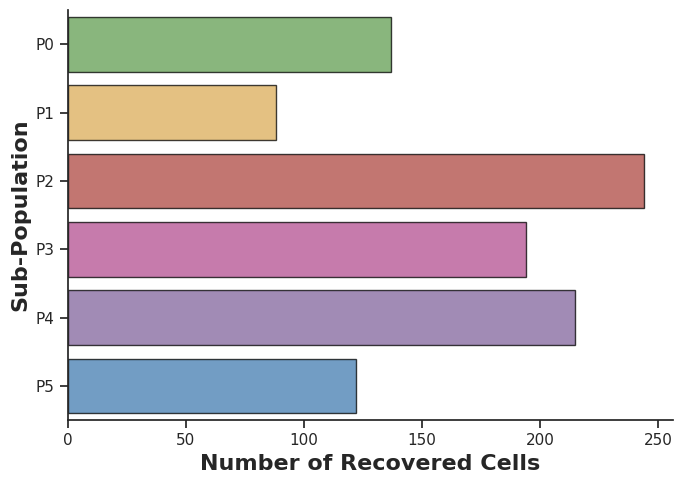

In [96]:
sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)
sns.barplot(
    data=pop_sizes,
    y='population',
    x='count',
    palette=pal,
    alpha=0.75,
    edgecolor="black",
    linewidth=1,
)
plt.xlabel('Number of Recovered Cells', fontweight='bold', fontsize=16)
plt.ylabel('Sub-Population', fontweight='bold', fontsize=16)
new_labels = ['P0', 'P1', 'P2', 'P3', 'P4', 'P5'] 
ax.set_yticklabels(new_labels)
plt.tight_layout()
f.savefig('figures/cells_per_subpop.png', dpi=600, bbox_inches='tight')

/loc/scratch/25689862/ipykernel_12588/2937754673.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
/loc/scratch/25689862/ipykernel_12588/2937754673.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


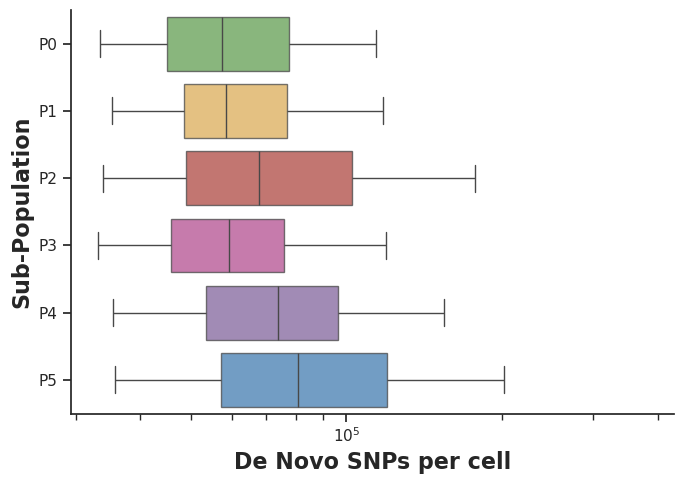

In [33]:
sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)
ax = sns.boxplot(
    data=adata.obs,
    y='pop',
    x='SNP_count_de_novo',
    palette=pal,
    fliersize=0 
)
ax.set_xscale('log')
for patch in ax.patches:
    patch.set_alpha(0.75) 
# plt.xlim(10e3,10e5)
plt.xlabel('De Novo SNPs per cell', fontweight='bold', fontsize=16)
plt.ylabel('Sub-Population', fontweight='bold', fontsize=16)

new_labels = ['P0', 'P1', 'P2', 'P3', 'P4', 'P5'] 
ax.set_yticklabels(new_labels)

plt.tight_layout()
f.savefig('figures/SNPs_per_cell.png', dpi=600, bbox_inches='tight')

In [28]:
adata.obs.to_csv('results/snp_counts.csv')

In [99]:
pop_sizes.to_csv('results/pop_sizes.csv')

In [29]:
adata.var.to_csv('results/bulk_vaf.csv')

In [30]:
adata.var

,tot_depth_bulk,alt_depth_bulk,bulk_VAF_raw,bulk_VAF_cor,count_of_cells
chr10-10295-T>G,165.0,3.0,0.018182,0.01,1.0
chr10-18791-A>T,108.0,20.0,0.185185,0.19,1.0
chr10-18800-A>T,100.0,10.0,0.100000,0.10,1.0
chr10-18867-T>C,109.0,10.0,0.091743,0.10,1.0
chr10-18923-A>C,142.0,107.0,0.753521,0.75,9.0
...,...,...,...,...,...
chrY-56887101-G>T,320.0,50.0,0.156250,0.20,6.0
chrY-56887117-G>T,163.0,20.0,0.122699,0.12,0.0
chrY-56887124-T>A,150.0,20.0,0.133333,0.09,0.0
chrY-56887128-T>C,130.0,6.0,0.046154,0.05,1.0


### Grouped VAF

In [102]:
min_DP = 50
num_bins = 10
bin_edges = np.linspace(0, 1, num_bins + 1) 

histograms = {pop: np.zeros(num_bins, dtype=int) for pop in pops}

for pop in pops:
    subset = adata[adata.obs['pop'] == pop].copy()
    AD = np.ravel(subset.layers['AD'].sum(axis=0)).astype(int)
    DP = np.ravel(subset.layers['DP'].sum(axis=0)).astype(int)

    # Filters
    mask = (DP > min_DP) & (AD > 1) & (AD != DP)
    AD = AD[mask]
    DP = DP[mask]

    VAF = downsample_vaf(AD, DP, min_DP)  # min_DP still controls downsampling depth

    bin_idx = np.digitize(VAF, bin_edges) - 1
    for idx in bin_idx:
        if 0 <= idx < num_bins:
            histograms[pop][idx] += 1

group_VAF = pd.DataFrame.from_dict(histograms, orient="index", columns=[f"bin_{i}" for i in range(num_bins)])

# group_VAF

In [103]:
group_VAF['pop'] = pops
df_melted = group_VAF.melt(id_vars=["pop"], var_name="bin")
df_melted["bin"] = df_melted["bin"].str.extract("(\d+)").astype(int)
# df_melted

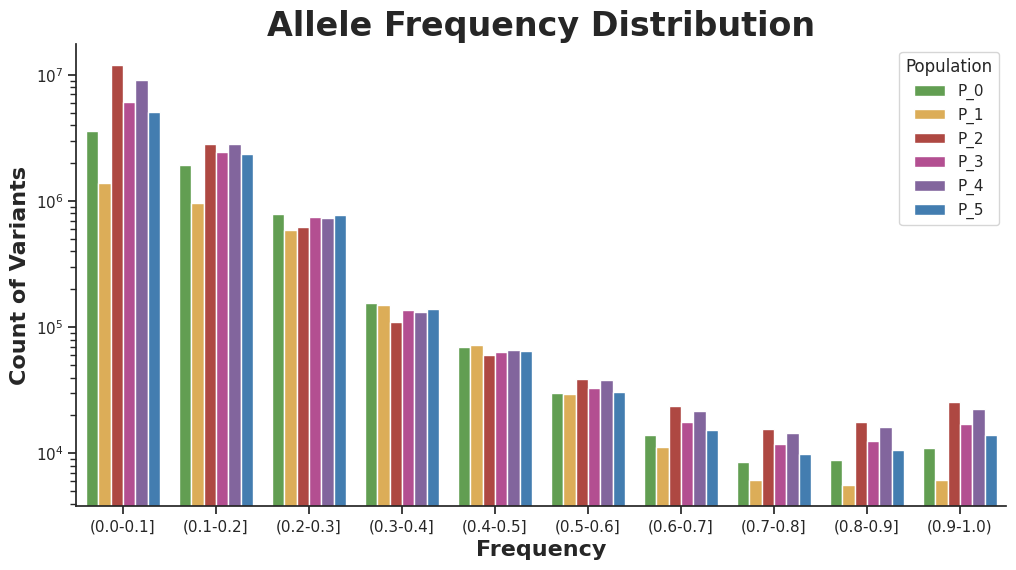

In [104]:
fig,ax = plt.subplots(1,1,figsize=(12, 6))
sns.barplot(data=df_melted, x="bin", y="value", hue="pop", palette=pal, errorbar=None, ax = ax)
plt.xlabel("Frequency", fontweight='bold', fontsize=16)
plt.ylabel("Count of Variants", fontweight='bold', fontsize=16)
plt.title("Allele Frequency Distribution", fontweight='bold', fontsize=24)
plt.legend(title="Population")
# Define bin labels
bin_edges = np.linspace(0, 1, 11)  # If min_DP = 10, 11 edges
bin_labels = [f"({bin_edges[i]:.1f}-{bin_edges[i+1]:.1f}]" for i in range(len(bin_edges)-2)]
bin_labels.append("(0.9-1.0)")
plt.xticks(ticks=np.arange(len(bin_labels)), labels=bin_labels, rotation=0)
sns.despine()
ax.set_yscale('log')
fig.savefig('figures/grouped_allele_freq.png')

In [105]:
group_VAF.to_csv('results/group_VAF.csv')

# Mutation Spectra

In [103]:
def reverse_complement(seq):
    return str(Seq(seq).reverse_complement())

def standardize_context(context):
    ref = context[1]
    if ref in {"T", "G"}:
        # Reverse complement both sides
        tri_from, tri_to = context.split(">")
        tri_from_rc = reverse_complement(tri_from)
        tri_to_rc = reverse_complement(tri_to)
        return f"{tri_from_rc}>{tri_to_rc}"
    else:
        return context


In [104]:
categories = [v for v in list(adata.var['context'].unique()) if 'N' not in v]

In [105]:
standardized_contexts = sorted(set(standardize_context(c) for c in categories))
print(standardized_contexts)

['AAA>ACA', 'AAA>AGA', 'AAA>ATA', 'AAC>ACC', 'AAC>AGC', 'AAC>ATC', 'AAG>ACG', 'AAG>AGG', 'AAG>ATG', 'AAT>ACT', 'AAT>AGT', 'AAT>ATT', 'ACA>AAA', 'ACA>AGA', 'ACA>ATA', 'ACC>AAC', 'ACC>AGC', 'ACC>ATC', 'ACG>AAG', 'ACG>AGG', 'ACG>ATG', 'ACT>AAT', 'ACT>AGT', 'ACT>ATT', 'CAA>CCA', 'CAA>CGA', 'CAA>CTA', 'CAC>CCC', 'CAC>CGC', 'CAC>CTC', 'CAG>CCG', 'CAG>CGG', 'CAG>CTG', 'CAT>CCT', 'CAT>CGT', 'CAT>CTT', 'CCA>CAA', 'CCA>CGA', 'CCA>CTA', 'CCC>CAC', 'CCC>CGC', 'CCC>CTC', 'CCG>CAG', 'CCG>CGG', 'CCG>CTG', 'CCT>CAT', 'CCT>CGT', 'CCT>CTT', 'GAA>GCA', 'GAA>GGA', 'GAA>GTA', 'GAC>GCC', 'GAC>GGC', 'GAC>GTC', 'GAG>GCG', 'GAG>GGG', 'GAG>GTG', 'GAT>GCT', 'GAT>GGT', 'GAT>GTT', 'GCA>GAA', 'GCA>GGA', 'GCA>GTA', 'GCC>GAC', 'GCC>GGC', 'GCC>GTC', 'GCG>GAG', 'GCG>GGG', 'GCG>GTG', 'GCT>GAT', 'GCT>GGT', 'GCT>GTT', 'TAA>TCA', 'TAA>TGA', 'TAA>TTA', 'TAC>TCC', 'TAC>TGC', 'TAC>TTC', 'TAG>TCG', 'TAG>TGG', 'TAG>TTG', 'TAT>TCT', 'TAT>TGT', 'TAT>TTT', 'TCA>TAA', 'TCA>TGA', 'TCA>TTA', 'TCC>TAC', 'TCC>TGC', 'TCC>TTC', 'TCG>TAG'

In [119]:
context_series = adata[:,adata.var['context'].isin(standardized_contexts)].var['context']

In [120]:
context_series = adata.var["context"].map(standardize_context)

In [121]:
context_to_indices = {
    context: adata.var_names.get_indexer(var_ids)
    for context, var_ids in context_series.groupby(context_series).groups.items()
}

/loc/scratch/22006024/ipykernel_13482/877953378.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for context, var_ids in context_series.groupby(context_series).groups.items()


In [122]:
spectra = pd.DataFrame(0, index=adata.obs_names, columns=sorted(context_to_indices.keys()), dtype=int)

In [123]:
for context, var_indices in context_to_indices.items():
    X_slice = adata.X[:, list(var_indices)]
    counts = X_slice.sum(axis=1)  # sum across those variants for each cell

    counts = counts.A1  # convert (n,1) sparse matrix to flat array

    spectra[context] = counts

In [124]:
spectra.to_csv('results/sc_spectra.csv')

In [125]:
titles = [
    'C>A',
    'C>G',
    'C>T',
    'A>T',
    'A>G',
    'A>C'
]

In [126]:
mut_types = {t:[] for t in titles}

for mut in spectra.columns.to_list():
    # C/G mutations
    if mut[1]=='C' and mut[-2]=='A':
        mut_types['C>A'].append(mut)
    elif mut[1]=='C' and mut[-2]=='G':
        mut_types['C>G'].append(mut)
    elif mut[1]=='C' and mut[-2]=='T':
        mut_types['C>T'].append(mut)

    # A/T mutations
    elif mut[1]=='A' and mut[-2]=='T':
        mut_types['A>T'].append(mut)
    elif mut[1]=='A' and mut[-2]=='G':
        mut_types['A>G'].append(mut)
    elif mut[1]=='A' and mut[-2]=='C':
        mut_types['A>C'].append(mut)
# mut_types    

In [127]:
hex_cols = [
    '#438CFD',
    '#01182E',
    '#ff1A5E',
    '#E6E6E6',
    '#80F15D',
    '#FFDB58'
]

In [ ]:
## Bulk Spectra (All mutations)

In [128]:
bulk_spectra = spectra.sum()

/loc/scratch/22006024/ipykernel_13482/1511153660.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x,rotation=90)
/loc/scratch/22006024/ipykernel_13482/1511153660.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x,rotation=90)
/loc/scratch/22006024/ipykernel_13482/1511153660.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x,rotation=90)
/loc/scratch/22006024/ipykernel_13482/1511153660.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x,rotation=90)
/loc/scratch/22006024/ipykernel_13482/1511153660.py:10: UserWarning: set_ticklabels() should only be used with a fixed n

Text(0.5, 0.98, 'Bulked Spectra')

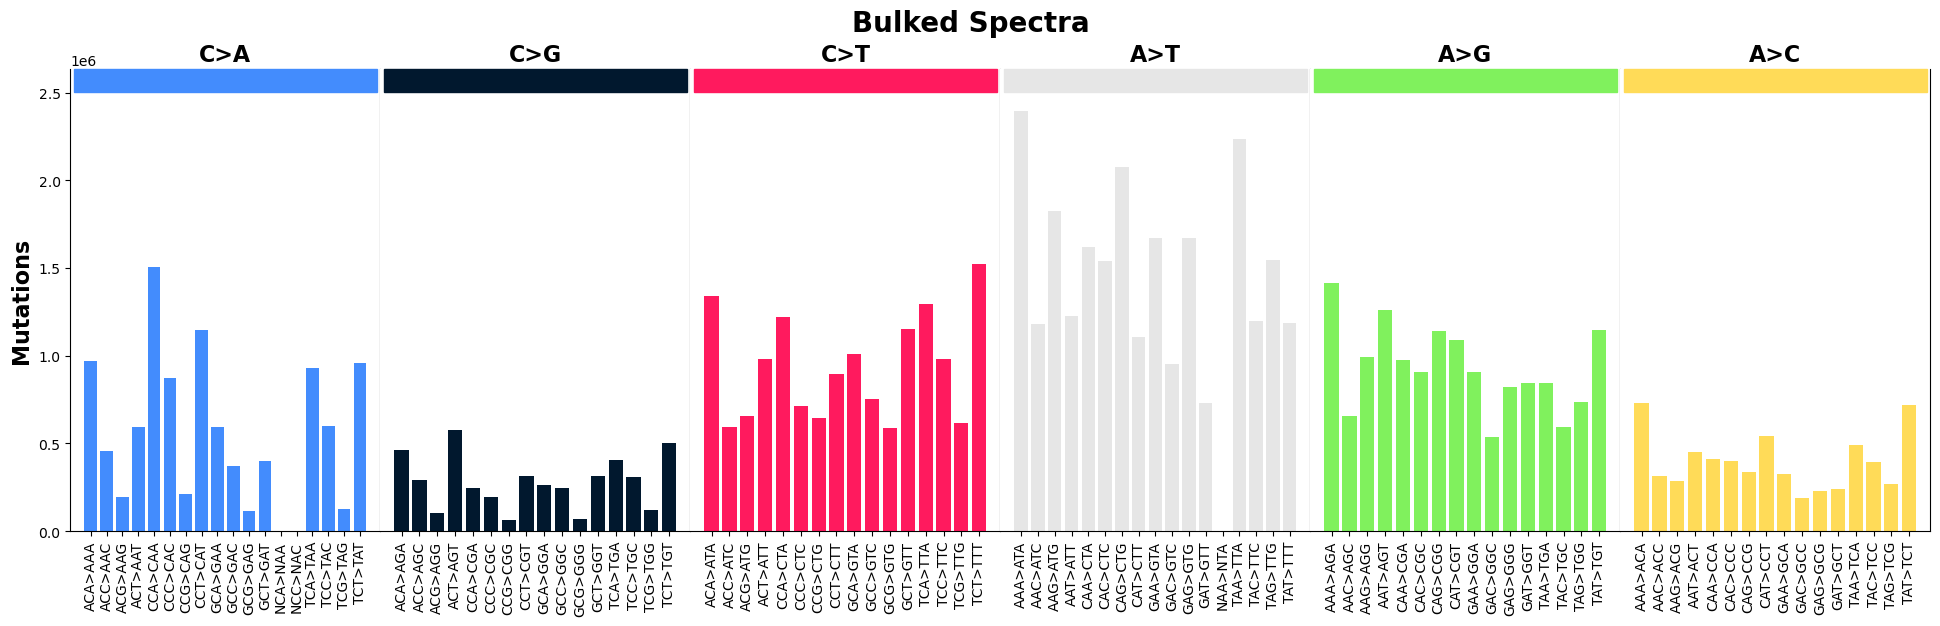

In [129]:
data = bulk_spectra
fig, axes = plt.subplots(1,6,figsize=(24,6), sharey=True, gridspec_kw={'wspace': 0})
for i, ax in enumerate(axes):
    x = mut_types[titles[i]]
    ax.bar(x, data[x], color=hex_cols[i])
    ax.set_title(f"{titles[i]}",
                 fontweight='bold', 
                 fontsize=16
                )
    ax.set_xticklabels(x,rotation=90)

    rect = patches.Rectangle(
        (0.01, 0.95),  # Bottom left corner of the rectangle (relative to axis coordinates)
        0.98, 0.05,     # Width and height (relative to axis coordinates)
        transform=ax.transAxes,  # Use axis coordinates
        color=hex_cols[i],         # Color of the patch
        clip_on=False            # Ensure the patch extends outside the axis
    )
    ax.add_patch(rect)
    ax.spines["top"].set_visible(False)
    ax.set_ylim(max(data))
    if i == 0:
        # Add y-axis label only to the first subplot
        ax.set_ylabel("Mutations", fontweight='bold', fontsize=16)
    else:
        # Remove the y-axis line and ticks for other subplots
        ax.yaxis.set_visible(False)
        ax.spines["left"].set_visible(False)

axes[0].set_ylim(0, max(data)+0.1*max(data))
# axes[0].set_ylim(0, 350)
fig.suptitle("Bulked Spectra",fontweight='bold', fontsize=20)
# fig.savefig('figures/HDR2_spectra_norm.png', dpi=600, bbox_inches='tight')

In [ ]:
## Bulk Spectra (No singletons)

In [89]:
mask = (np.ravel(adata.X.sum(axis=0))>1)
adata = adata[:,mask].copy()

In [90]:
context_series = adata[:,adata.var['context'].isin(categories)].var['context']

In [91]:
context_series = adata.var["context"].map(standardize_context)

In [92]:
context_to_indices = {
    context: adata.var_names.get_indexer(var_ids)
    for context, var_ids in context_series.groupby(context_series).groups.items()
}

/loc/scratch/22006024/ipykernel_13482/877953378.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for context, var_ids in context_series.groupby(context_series).groups.items()


In [93]:
spectra = pd.DataFrame(0, index=adata.obs_names, columns=sorted(context_to_indices.keys()), dtype=int)

In [94]:
for context, var_indices in context_to_indices.items():
    X_slice = adata.X[:, list(var_indices)]
    counts = X_slice.sum(axis=1)  # sum across those variants for each cell

    counts = counts.A1  # convert (n,1) sparse matrix to flat array

    spectra[context] = counts

In [95]:
spectra.to_csv('results/sc_spectra_no_singletons.csv')

In [96]:
titles = [
    'C>A',
    'C>G',
    'C>T',
    'A>T',
    'A>G',
    'A>C'
]

In [97]:
mut_types = {t:[] for t in titles}

for mut in spectra.columns.to_list():
    # C/G mutations
    if mut[1]=='C' and mut[-2]=='A':
        mut_types['C>A'].append(mut)
    elif mut[1]=='C' and mut[-2]=='G':
        mut_types['C>G'].append(mut)
    elif mut[1]=='C' and mut[-2]=='T':
        mut_types['C>T'].append(mut)

    # A/T mutations
    elif mut[1]=='A' and mut[-2]=='T':
        mut_types['A>T'].append(mut)
    elif mut[1]=='A' and mut[-2]=='G':
        mut_types['A>G'].append(mut)
    elif mut[1]=='A' and mut[-2]=='C':
        mut_types['A>C'].append(mut)
# mut_types    

In [98]:
hex_cols = [
    '#438CFD',
    '#01182E',
    '#ff1A5E',
    '#E6E6E6',
    '#80F15D',
    '#FFDB58'
]

In [99]:
## Bulk Spectra (All mutations)

In [100]:
bulk_spectra = spectra.sum()

/loc/scratch/22006024/ipykernel_13482/46589432.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x,rotation=90)
/loc/scratch/22006024/ipykernel_13482/46589432.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x,rotation=90)
/loc/scratch/22006024/ipykernel_13482/46589432.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x,rotation=90)
/loc/scratch/22006024/ipykernel_13482/46589432.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x,rotation=90)
/loc/scratch/22006024/ipykernel_13482/46589432.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of t

Text(0.5, 0.98, 'Bulked Spectra No Singletons')

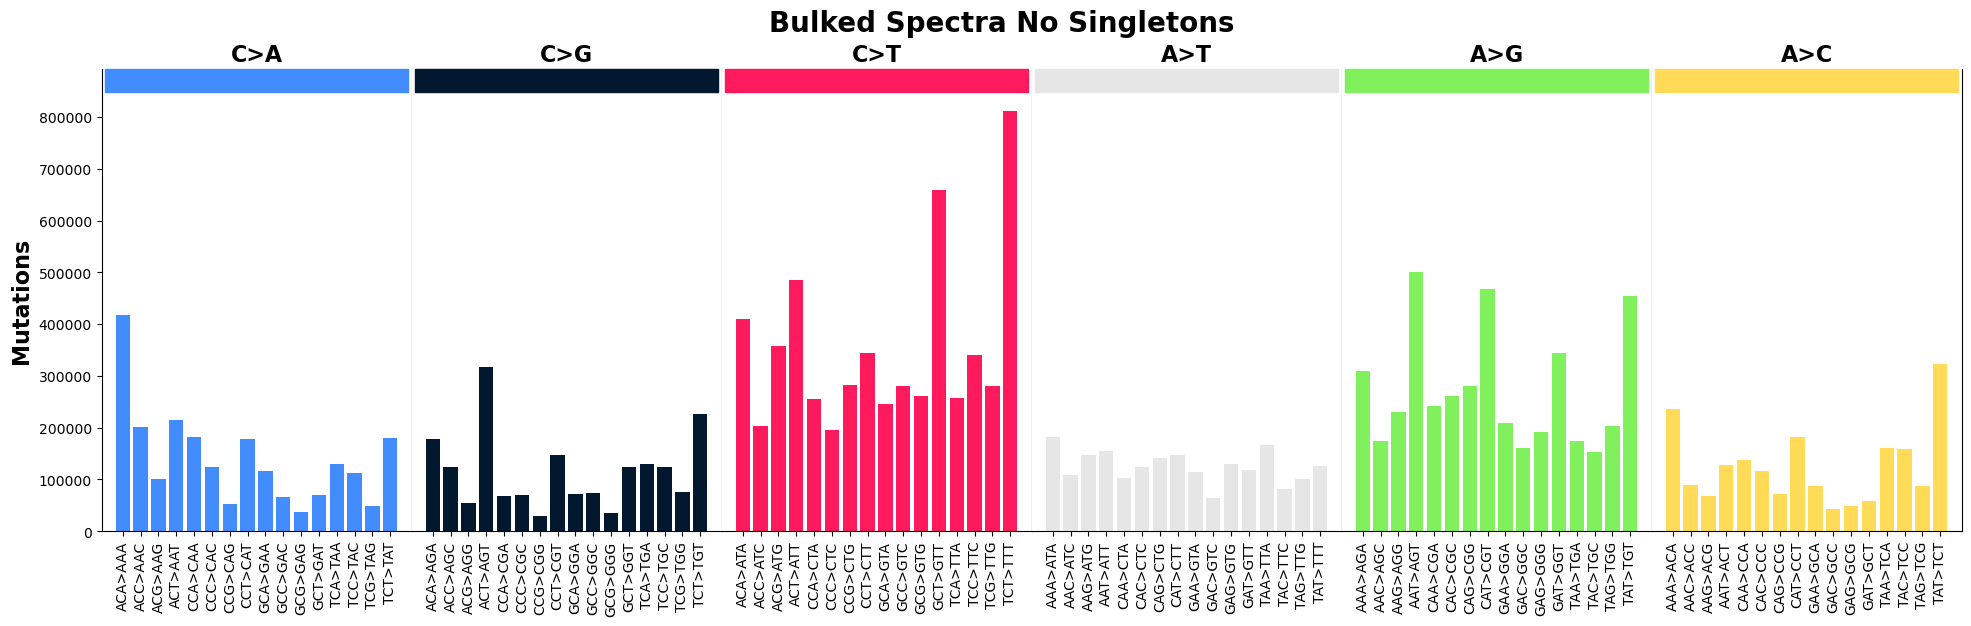

In [101]:
data = bulk_spectra
fig, axes = plt.subplots(1,6,figsize=(24,6), sharey=True, gridspec_kw={'wspace': 0})
for i, ax in enumerate(axes):
    x = mut_types[titles[i]]
    ax.bar(x, data[x], color=hex_cols[i])
    ax.set_title(f"{titles[i]}",
                 fontweight='bold', 
                 fontsize=16
                )
    ax.set_xticklabels(x,rotation=90)

    rect = patches.Rectangle(
        (0.01, 0.95),  # Bottom left corner of the rectangle (relative to axis coordinates)
        0.98, 0.05,     # Width and height (relative to axis coordinates)
        transform=ax.transAxes,  # Use axis coordinates
        color=hex_cols[i],         # Color of the patch
        clip_on=False            # Ensure the patch extends outside the axis
    )
    ax.add_patch(rect)
    ax.spines["top"].set_visible(False)
    ax.set_ylim(max(data))
    if i == 0:
        # Add y-axis label only to the first subplot
        ax.set_ylabel("Mutations", fontweight='bold', fontsize=16)
    else:
        # Remove the y-axis line and ticks for other subplots
        ax.yaxis.set_visible(False)
        ax.spines["left"].set_visible(False)

axes[0].set_ylim(0, max(data)+0.1*max(data))
# axes[0].set_ylim(0, 350)
fig.suptitle("Bulked Spectra No Singletons",fontweight='bold', fontsize=20)
# fig.savefig('figures/HDR2_spectra_norm.png', dpi=600, bbox_inches='tight')

# Tree Construction

### Filter out other non-informative variants

* any that are present in only 1 cell



In [106]:
mask = (np.ravel(adata.X.sum(axis=0))>1)
adata = adata[:,mask].copy()
adata

AnnData object with n_obs × n_vars = 1000 × 3095002
    obs: 'pop', 'SNP_count', 'tot_observed_sites', 'mito_snps', 'germline_count', 'SNP_count_de_novo'
    var: 'tot_depth_bulk', 'alt_depth_bulk', 'bulk_VAF_raw', 'bulk_VAF_cor'
    layers: 'AD', 'DP'

In [107]:
adata.write_h5ad("sc_PolE_filtered_no_singletons.h5ad")

In [27]:
adata = sc.read_h5ad('sc_PolE_filtered_no_singletons.h5ad')

### Create list of informative features

- only those shared by all cells within a subpop ❌

- top observed features accross all cells? 

- top observed features within each subpop?

In [109]:
## Odds ratio

n_features = 5000
pop_features = {}
ordered_pops = ['P_5', 'P_4', 'P_3', 'P_2', 'P_1', 'P_0']

features = []
top_all = pd.Series(np.ravel(adata.X.sum(axis=0)), index=adata.var_names).sort_values(ascending=False)[:n_features].index.to_list()
features += top_all
for i, pop in enumerate(ordered_pops):
    pop_cells = adata[adata.obs['pop'] == pop, ~adata.var_names.isin(top_all)]
    pop_X = pop_cells.X
    
    count_with = np.ravel(pop_X.sum(axis=0))
    count_without = pop_cells.n_obs - count_with
    
    # pop_frac = np.ravel(pop_X.sum(axis=0)) / pop_X.shape[0]
    # pop_frac_series = pd.Series(pop_frac, index=adata.var_names)
    
    # pop_frac_series.drop(labels=top_all, errors='ignore')
    
    # top = enrichment.sort_values(ascending=False)[:n_features].index.to_list()
    
    if i == 0:
        # No previous populations to compare against
        count_with_series = pd.Series(count_with, index=pop_cells.var_names)
        top = count_with_series.sort_values(ascending=False)[:n_features].index.to_list()
    else:
        # Combine all previous subpopulations
        prev_pops = ordered_pops[:i]
        prev_cells = adata[adata.obs['pop'].isin(prev_pops), ~adata.var_names.isin(top_all)]
        prev_X = prev_cells.X
        
        prev_count_with = np.ravel(prev_X.sum(axis=0))
        prev_count_without = prev_cells.n_obs - prev_count_with
        
        # Apply 0.5 continuity correction to avoid division by zero
        a = count_with + 0.5
        b = count_without + 0.5
        c = prev_count_with + 0.5
        d = prev_count_without + 0.5

        # Compute odds ratios vectorized
        odds_ratios = (a * d) / (b * c)
        odds_ratios_series = pd.Series(odds_ratios, index=pop_cells.var_names)

        # Rank features most enriched in this population
        top = odds_ratios_series.sort_values(ascending=False)[:n_features].index.to_list()
    
    pop_features[pop] = top
    features += top

In [110]:
for pop in ordered_pops:
    adata.obs[f'{pop} Features'] = np.ravel(adata[:,adata.var_names.isin(pop_features[pop])].X.sum(axis=1))
# adata.obs

In [111]:
df_long = adata.obs.reset_index().melt(
    id_vars='pop',  # the grouping column
    value_vars=['P_5 Features', 'P_4 Features', 'P_3 Features', 'P_2 Features', 'P_1 Features', 'P_0 Features'],  # your variant sets
    var_name='feature_set',
    value_name='count'
)

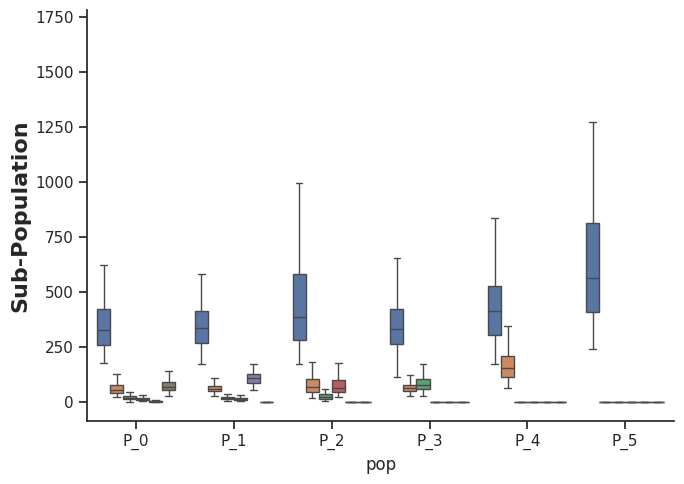

In [112]:
sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)
ax = sns.boxplot(data=df_long, x='pop', y='count', hue='feature_set', fliersize=0, legend=False)
# sns.stripplot(data=df_long, x='pop', y='count', hue='feature_set', s=2,
#               dodge=True, jitter=True, legend=False)
# ax.set_yscale('log')
# ax.set_ylim(-1,15)
# for patch in ax.patches:
#     patch.set_alpha(0.75) 
# plt.xlim(10e3,10e5)
# plt.xlabel('De Novo SNPs per cell', fontweight='bold', fontsize=16)
plt.ylabel('Sub-Population', fontweight='bold', fontsize=16)

# new_labels = ['P0', 'P1', 'P2', 'P3', 'P4', 'P5'] 
# ax.set_yticklabels(new_labels)

plt.tight_layout()

### Simple Tree 

In [55]:
## Odds ratio

n_features = 100
pop_features = {}
ordered_pops = ['P_5', 'P_4', 'P_3', 'P_2', 'P_1', 'P_0']

features = []
top_all = pd.Series(np.ravel(adata.X.sum(axis=0)), index=adata.var_names).sort_values(ascending=False)[:n_features].index.to_list()
features += top_all
for i, pop in enumerate(ordered_pops):
    pop_cells = adata[adata.obs['pop'] == pop, ~adata.var_names.isin(top_all)]
    pop_X = pop_cells.X
    
    count_with = np.ravel(pop_X.sum(axis=0))
    count_without = pop_cells.n_obs - count_with
    
    # pop_frac = np.ravel(pop_X.sum(axis=0)) / pop_X.shape[0]
    # pop_frac_series = pd.Series(pop_frac, index=adata.var_names)
    
    # pop_frac_series.drop(labels=top_all, errors='ignore')
    
    # top = enrichment.sort_values(ascending=False)[:n_features].index.to_list()
    
    if i == 0:
        # No previous populations to compare against
        count_with_series = pd.Series(count_with, index=pop_cells.var_names)
        top = count_with_series.sort_values(ascending=False)[:n_features].index.to_list()
    else:
        # Combine all previous subpopulations
        prev_pops = ordered_pops[:i]
        prev_cells = adata[adata.obs['pop'].isin(prev_pops), ~adata.var_names.isin(top_all)]
        prev_X = prev_cells.X
        
        prev_count_with = np.ravel(prev_X.sum(axis=0))
        prev_count_without = prev_cells.n_obs - prev_count_with
        
        # Apply 0.5 continuity correction to avoid division by zero
        a = count_with + 0.5
        b = count_without + 0.5
        c = prev_count_with + 0.5
        d = prev_count_without + 0.5

        # Compute odds ratios vectorized
        odds_ratios = (a * d) / (b * c)
        odds_ratios_series = pd.Series(odds_ratios, index=pop_cells.var_names)

        # Rank features most enriched in this population
        top = odds_ratios_series.sort_values(ascending=False)[:n_features].index.to_list()
    
    pop_features[pop] = top
    features += top

In [114]:
X_rows = []

for pop in pops:
    pop_cells = adata[adata.obs['pop'] == pop, features]
    group_vector = pop_cells.X.max(axis=0)
    X_rows.append(group_vector)

# Stack into dense matrix
grouped_X = vstack(X_rows).toarray()

# Optionally: filter variants present in ≥2 populations
pop_counts_per_variant = grouped_X.sum(axis=0)
keep_mask = pop_counts_per_variant >= 2
grouped_X_filtered = grouped_X[:, keep_mask]

# Compute Hamming distances
pdist = ssd.squareform(ssd.pdist(grouped_X_filtered, metric='hamming'))

# Build NJ tree
dm = DistanceMatrix(pdist, ids=pops)
tree = nj(dm)
# tree = gme(dm)
# tree = bme(dm)
# tree = nni(tree, dm)
tree = tree.root_by_outgroup(['P_5'])

tree.write('results/grouped_initial.newick')

'results/grouped_initial.newick'

<Axes: >

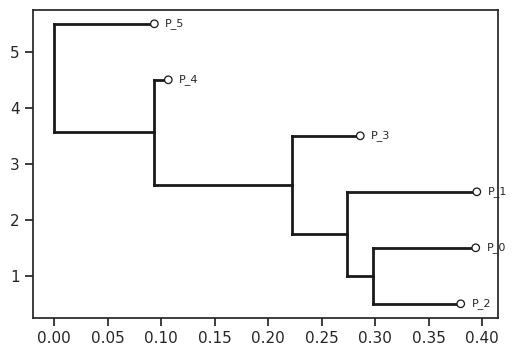

In [115]:
newickPath='results/grouped_initial.newick'
tree = bt.loadNewick(newickPath)

fig,ax = plt.subplots(figsize=(6,4))

# x_attr=lambda k: k.absoluteTime

tree.plotTree(ax)
tree.plotPoints(ax,size=20,colour='w',zorder=100) ## tips

target_func=lambda k: k.is_leaf() ## which branches will be annotated
text_func=lambda k: k.name
text_x_attr=lambda k: k.x+0.01
kwargs={'va':'center','ha':'left','size': 8} ## kwargs for text

tree.addText(ax,x_attr=text_x_attr,target=target_func,text=text_func,**kwargs) ## text will use a different x attribute function 


### Neighbor joining w/ bootstrapping:

bootstrapping by resampling *cells* from each group

In [116]:
pops = adata.obs['pop'].unique()
pop_sizes = adata.obs['pop'].value_counts().to_dict()
n_bootstraps = 5000
bootstrap_tree_list = dendropy.TreeList()

for i in tqdm(range(n_bootstraps)):
    X_rows = []
    for pop in pops:
        pop_cells = adata[adata.obs['pop'] == pop, features]
        n_cells = pop_sizes[pop]
        feature_idx = np.random.choice(np.arange(len(features)), size=len(features), replace=True)
        sampled = pop_cells[:,feature_idx]
        sampled_X = sampled.X
        
        # Take max over axis=0 to get group-level presence/absence vector
        group_vector = sampled_X.max(axis=0)
        X_rows.append(group_vector)

    # Stack into dense matrix
    grouped_X = vstack(X_rows).toarray()
    
    # Optionally: filter variants present in ≥2 populations
    pop_counts_per_variant = grouped_X.sum(axis=0)
    keep_mask = pop_counts_per_variant >= 2
    grouped_X_filtered = grouped_X[:, keep_mask]
    
    # Compute Hamming distances
    pdist = ssd.squareform(ssd.pdist(grouped_X_filtered, metric='hamming'))

    # Build NJ tree
    dm = DistanceMatrix(pdist, ids=pops)
    tree = nj(dm)
    # tree = gme(dm)
    # tree = bme(dm)
    # tree = nni(tree, dm)
    
    tree = tree.root_by_outgroup(['P_5'])
    
    handle = StringIO()
    tree.write(handle)
    newick_str = handle.getvalue()
    t = dendropy.Tree.get(data=newick_str, schema="newick")
    t.is_rooted = True
    bootstrap_tree_list.append(t)

100%|██████████| 5000/5000 [15:21<00:00,  5.43it/s]  


In [117]:
bootstrap_tree_list.write(
    path="results/grouped_bootstrap_trees.tre",
    schema="newick",
    suppress_rooting=False
)

In [126]:
!sumtrees --summary-target=mcct --decimals=0 --percentages --output-tree-filepath=results/grouped_bootstrap_consensus.tre --force-rooted results/grouped_bootstrap_trees.tre

/==========================================================================\
|                                 SumTrees                                 |
|                     Phylogenetic Tree Summarization                      |
|                              Version 5.0.1                               |
|                   By Jeet Sukumaran and Mark T. Holder                   |
|                         Using: DendroPy 5.0.1 ()                         |
+--------------------------------------------------------------------------+
|                                 Citation                                 |
|                                 ~~~~~~~~                                 |
| If any stage of your work or analyses relies on code or programs from    |
| this library, either directly or indirectly (e.g., through usage of your |
| own or third-party programs, pipelines, or toolkits which use, rely on,  |
| incorporate, or are otherwise primarily derivative of code/programs in   |

In [127]:
# Load the consensus tree
tree = dendropy.Tree.get(path="results/grouped_bootstrap_consensus.tre", schema="nexus")

# Write the resolved tree to a new file
tree.write(path="results/grouped_bootstrap_consensus.newick", schema="newick")

In [128]:
with open("results/grouped_bootstrap_consensus.tre") as f:
    tree_string = f.read()

# Extract support values and attach them to internal nodes
def extract_supports(tree_string):
    support_pattern = re.compile(r'\)[^\)]*?\[\&support=([0-9.]+)\]')
    supports = [float(s) for s in support_pattern.findall(tree_string)]
    return supports

support_values = extract_supports(tree_string)
support_values = support_values[:-1]  # drop root support val

newickPath='results/grouped_bootstrap_consensus.newick'
tree = bt.loadNewick(newickPath)

# Attach support values to internal nodes in postorder
internal_nodes = [n for n in tree.Objects if n.is_leaf()==False]
assert len(internal_nodes) == len(support_values), "Support count doesn't match internal nodes"

# Assign support as a trait
for node, support in zip(internal_nodes, support_values):
    node.traits['support'] = support

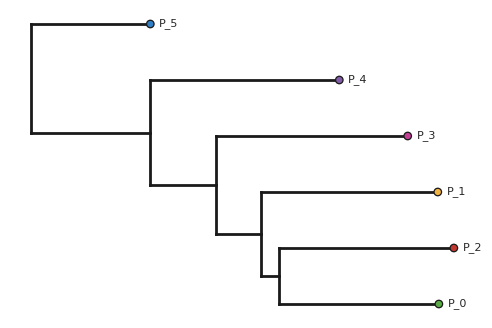

In [129]:
fig,ax = plt.subplots(figsize=(6,4))

# x_attr=lambda k: k.absoluteTime
c_func=lambda n: pal[n.name]

tree.plotTree(ax)
tree.plotPoints(ax,size=20,colour=c_func,zorder=100) ## tips

target_func=lambda k: k.is_leaf() ## which branches will be annotated
text_func=lambda k: k.name
text_x_attr=lambda k: k.x+0.01
kwargs={'va':'center','ha':'left','size': 8} ## kwargs for text

tree.addText(ax,x_attr=text_x_attr,target=target_func,text=text_func,**kwargs) ## text will use a different x attribute function 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

fig.savefig('figures/grouped_consensus_tree_c.png', dpi=600)

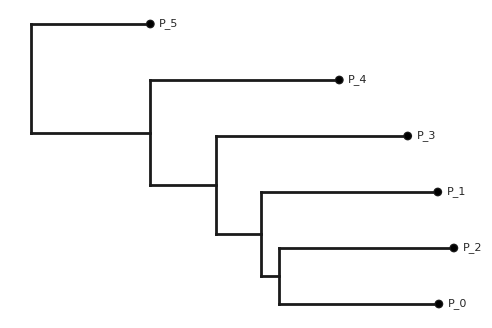

In [131]:
fig,ax = plt.subplots(figsize=(6,4))

# x_attr=lambda k: k.absoluteTime
c_func=lambda n: pal[n.name]

tree.plotTree(ax)
tree.plotPoints(ax,size=20,colour='black',zorder=100) ## tips

target_func=lambda k: k.is_leaf() ## which branches will be annotated
text_func=lambda k: k.name
text_x_attr=lambda k: k.x+0.01
kwargs={'va':'center','ha':'left','size': 8} ## kwargs for text

tree.addText(ax,x_attr=text_x_attr,target=target_func,text=text_func,**kwargs) ## text will use a different x attribute function 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
fig.savefig('figures/grouped_consensus_tree.png', dpi=600)

## Single Cell Tree Construction

### Test a simple neighbor joining tree

In [132]:
X = adata[:,features].X.toarray()

distance_array = ssd.pdist(X, metric="hamming")
distance_matrix = ssd.squareform(distance_array)

# Build distance matrix and tree
dm = DistanceMatrix(distance_matrix, ids=adata.obs_names.tolist())
tree = nj(dm)
tree = nni(tree, dm)

tree = tree.root_by_outgroup([np.random.choice(adata.obs[adata.obs['pop']=='P_5'].index, 1)[0]])
tree.write('results/sc_test.newick')

'results/sc_test.newick'

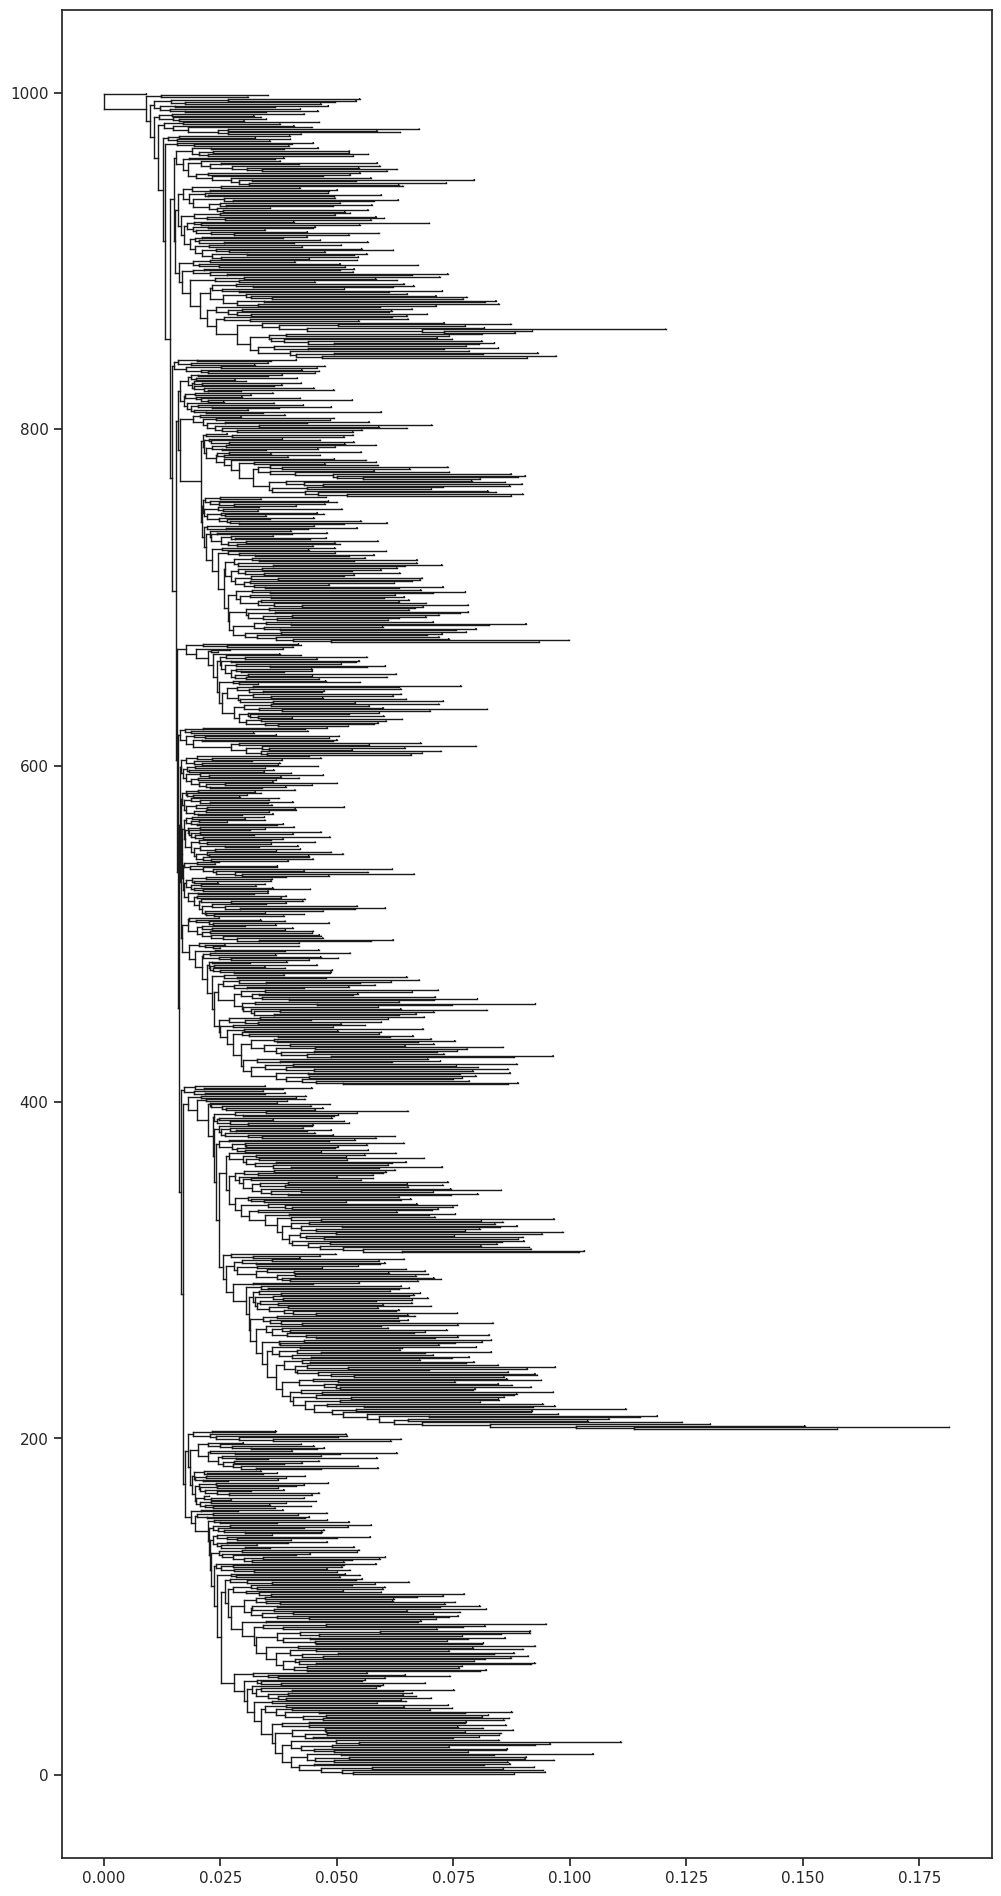

In [134]:
newickPath='results/sc_test.newick'
tree = bt.loadNewick(newickPath)

tips = [k for k in tree.Objects if k.is_leaf()]
tip_names = [k.name for k in tips]


fig,ax = plt.subplots(figsize=(12,24))

# x_attr=lambda k: k.absoluteTime

tree.plotTree(ax,width=1)
tree.plotPoints(ax,size=0.5,colour='black',
                zorder=100) ## tips

target_func=lambda k: k.is_leaf() ## which branches will be annotated
text_func=lambda k: k.name
text_x_attr=lambda k: k.x+0.01
kwargs={'va':'center','ha':'left','size': 8} ## kwargs for text

# tree.addText(ax,x_attr=text_x_attr,target=target_func,text=text_func,**kwargs) ## text will use a different x attribute function 
fig.savefig('figures/sc_test_tree.png', dpi=600)

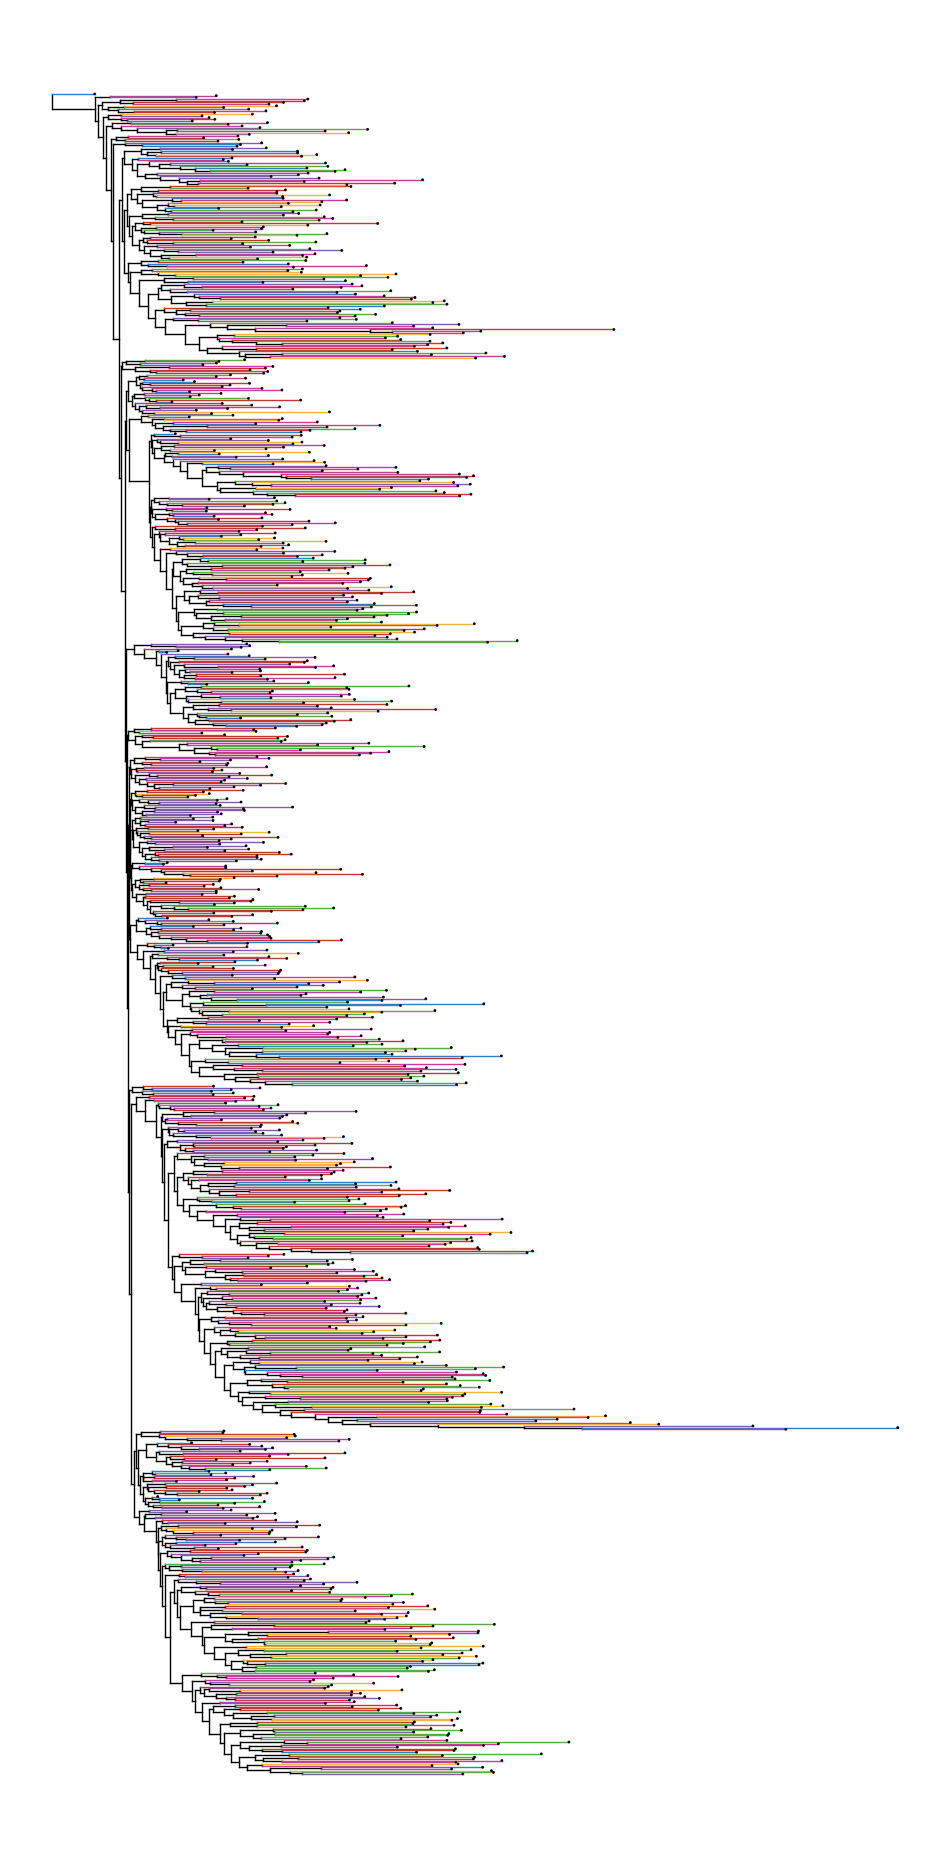

In [155]:
fig,ax = plt.subplots(figsize=(12,24))

# x_attr=lambda k: k.absoluteTime
c_func=lambda n: pal[adata.obs.loc[n.name]['pop']] if n.is_leaf() else 'black'

tree.plotTree(ax, width=1, colour=c_func)
tree.plotPoints(ax,size=2,colour='black',zorder=100) ## tips

target_func=lambda k: k.is_leaf() ## which branches will be annotated
text_func=lambda k: k.name
text_x_attr=lambda k: k.x+0.01
kwargs={'va':'center','ha':'left','size': 8} ## kwargs for text

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

fig.savefig('figures/sc_test_tree_c.png', dpi=600)

### Neighbor joining w/ psuedo-unedited cell outgroup

In [106]:
X = adata[:,features].X.toarray()
K562 = np.zeros(len(features))
X = np.append(X, K562.reshape(1, -1), axis=0)
cells = adata.obs_names.to_list()
cells.append('K562')

distance_array = ssd.pdist(X, metric="hamming")
distance_matrix = ssd.squareform(distance_array)

# Build distance matrix and tree
dm = DistanceMatrix(distance_matrix, ids=cells)
tree = nj(dm)
# tree = nni(tree, dm)

tree = tree.root_by_outgroup(['K562'])
tree.write('results/sc_og_test.newick')

'results/sc_og_test.newick'

In [103]:
newickPath='results/sc_og_test.newick'
tree = bt.loadNewick(newickPath)

tips = [k for k in tree.Objects if k.is_leaf()]
tip_names = [k.name for k in tips]

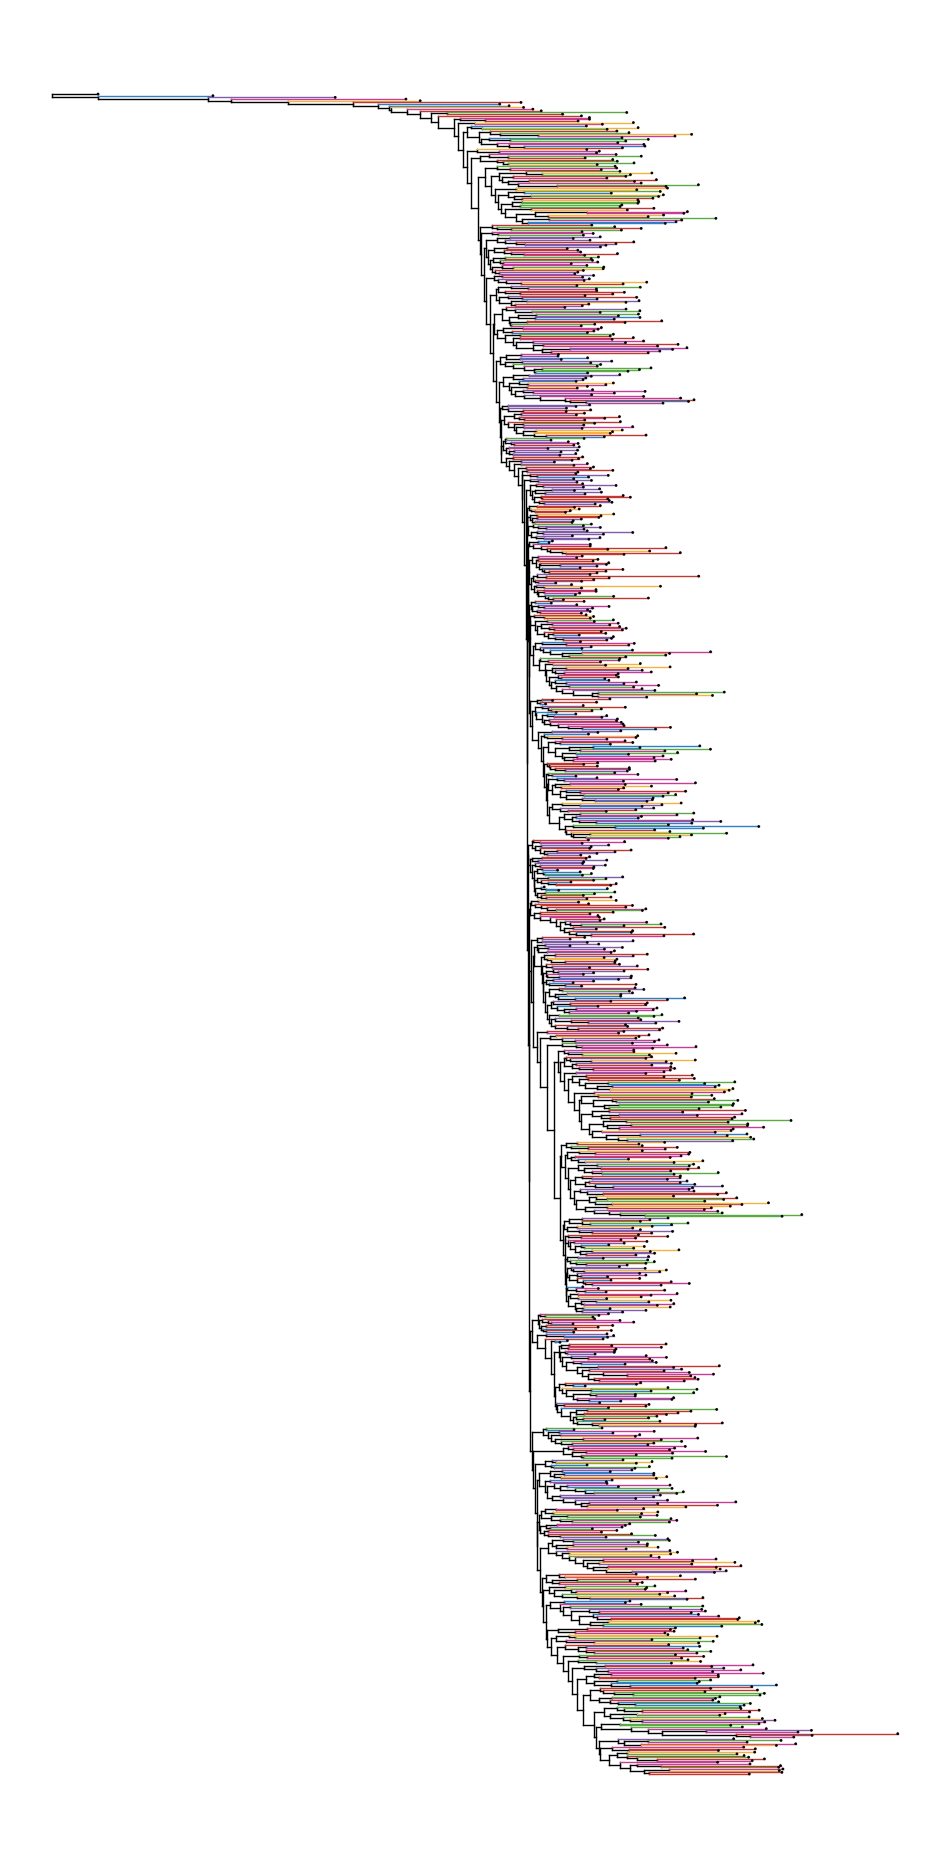

In [104]:
fig,ax = plt.subplots(figsize=(12,24))

# x_attr=lambda k: k.absoluteTime
c_func=lambda n: pal[adata.obs.loc[n.name]['pop']] if n.is_leaf() and n.name != 'K562' else 'black'

tree.plotTree(ax, width=1, colour=c_func)
tree.plotPoints(ax,size=2,colour='black',zorder=100) ## tips

target_func=lambda k: k.is_leaf() ## which branches will be annotated
text_func=lambda k: k.name
text_x_attr=lambda k: k.x+0.01
kwargs={'va':'center','ha':'left','size': 8} ## kwargs for text

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

fig.savefig('figures/sc_og_testtree_c.png', dpi=600)

### Neighbor joining w/ bootstrapping and pseudo-unedited cell outgroup

In [112]:
## Odds ratio

n_features = 1000
pop_features = {}
ordered_pops = ['P_5', 'P_4', 'P_3', 'P_2', 'P_1', 'P_0']

features = []
top_all = pd.Series(np.ravel(adata.X.sum(axis=0)), index=adata.var_names).sort_values(ascending=False)[:n_features].index.to_list()
features += top_all
for i, pop in enumerate(ordered_pops):
    pop_cells = adata[adata.obs['pop'] == pop, ~adata.var_names.isin(top_all)]
    pop_X = pop_cells.X
    
    count_with = np.ravel(pop_X.sum(axis=0))
    count_without = pop_cells.n_obs - count_with
    
    # pop_frac = np.ravel(pop_X.sum(axis=0)) / pop_X.shape[0]
    # pop_frac_series = pd.Series(pop_frac, index=adata.var_names)
    
    # pop_frac_series.drop(labels=top_all, errors='ignore')
    
    # top = enrichment.sort_values(ascending=False)[:n_features].index.to_list()
    
    if i == 0:
        # No previous populations to compare against
        count_with_series = pd.Series(count_with, index=pop_cells.var_names)
        top = count_with_series.sort_values(ascending=False)[:n_features].index.to_list()
    else:
        # Combine all previous subpopulations
        prev_pops = ordered_pops[:i]
        prev_cells = adata[adata.obs['pop'].isin(prev_pops), ~adata.var_names.isin(top_all)]
        prev_X = prev_cells.X
        
        prev_count_with = np.ravel(prev_X.sum(axis=0))
        prev_count_without = prev_cells.n_obs - prev_count_with
        
        # Apply 0.5 continuity correction to avoid division by zero
        a = count_with + 0.5
        b = count_without + 0.5
        c = prev_count_with + 0.5
        d = prev_count_without + 0.5

        # Compute odds ratios vectorized
        odds_ratios = (a * d) / (b * c)
        odds_ratios_series = pd.Series(odds_ratios, index=pop_cells.var_names)

        # Rank features most enriched in this population
        top = odds_ratios_series.sort_values(ascending=False)[:n_features].index.to_list()
    
    pop_features[pop] = top
    features += top

In [113]:
n_bootstraps = 1000
bootstrap_tree_list = dendropy.TreeList()

for i in tqdm(range(n_bootstraps)):
    
    feature_idx = np.random.choice(np.arange(len(features)), size=len(features), replace=True)
    sampled = adata[:,feature_idx]
    sampled_X = sampled.X.toarray()
    K562 = np.zeros(len(features))
    sampled_X = np.append(sampled_X, K562.reshape(1, -1), axis=0)
    cells = adata.obs_names.to_list()
    cells.append('K562')
    
    # Compute Hamming distances
    pdist = ssd.squareform(ssd.pdist(sampled_X, metric='hamming'))

    # Build NJ tree
    dm = DistanceMatrix(pdist, ids=cells)
    tree = nj(dm)
    # tree = gme(dm)
    # tree = bme(dm)
    # tree = nni(tree, dm)
    
    tree = tree.root_by_outgroup(['K562'])
    
    handle = StringIO()
    tree.write(handle)
    newick_str = handle.getvalue()
    t = dendropy.Tree.get(data=newick_str, schema="newick")
    t.is_rooted = True
    bootstrap_tree_list.append(t)

100%|██████████| 1000/1000 [39:50<00:00,  2.39s/it] 


In [114]:
bootstrap_tree_list.write(
    path="results/sc_bootstrap_trees.tre",
    schema="newick",
    suppress_rooting=False
)

# CNV Analysis

In [16]:
cnv = pd.read_csv('AneuFinder_output/result.csv', index_col=0)
cnv.index = cnv['seqnames'].astype(str) + ':' + cnv['start'].astype(str) + '-' + cnv['end'].astype(str)
cnv = cnv.drop(['seqnames', 'start', 'end'], axis=1)
cnv

,GTGAGACTAGGATGGTCACTACTCAGGACATCAAGGACATCGTCA,CGCTAGTTAGGAGTCTGCTAACTCGGAACTGTAAGGGTGACTCTA,GTAATGCCAGGACGACAAGAACTCACAGTAGCAAGGGTGACTCTA,ACCTCGTAAGGATACAGCAGACTCGGAACTGTAAGGCGGTTGATA,CGGTAGAAAGGAACCTTCAGACTCTCTGCTTGAAGGTTGACCACA,ATACGACCAGGAAACGATGGACTCCGAACTTGAAGGGTGACTCTA,CAACCAACAGGAGTCTGCTAACTCAGAATGCCAAGGGTGACTCTA,CGCTAGTTAGGAAACTGCTCACTCTCTGCTTGAAGGGTCGGTAAA,ACTAACCGAGGAAGATGGTCACTCTCTGGAACAAGGGTCCGATTA,GTAATGCCAGGAAGGCTAACACTCGCAATGACAAGGCTGTGAACA,...,GGTCATTGAGGACTGCTCAAACTCGGAACTGTAAGGTTGATGGCA,ATATGCGGAGGACACCTTGAACTCTGCTATGGAAGGCGACCTATA,ATCGACAGAGGAAACTGCTCACTCTCCAGTCTAAGGCGGTTGATA,CGGTAGAAAGGAAAGGTGACACTCTGCTATGGAAGGTTGGATGCA,CGGTAGAAAGGATACAGCAGACTCTACAACCGAAGGTGGTCTCAA,TACCACAGAGGACTTCAGCAACTCAGACGAACAAGGAGATACCGA,CGGTAGAAAGGAAACGATGGACTCAGAATGCCAAGGAGATACCGA,GTGAGACTAGGAAACTGCTCACTCCACCATCTAAGGTTGGATGCA,AAGGCTTGAGGACGACAAGAACTCCACCATCTAAGGCGGTAAGTA,GGTCATTGAGGAAACGATGGACTCTCCAGTCTAAGGGATGGTCTA
chr1:1-3000000,1,2,1,2,1,3,2,2,2,3,...,1,2,2,2,2,1,2,2,2,2
chr1:3000001-4000000,1,2,1,2,1,3,2,2,2,3,...,1,2,2,2,2,1,2,2,2,2
chr1:4000001-5000000,2,2,2,2,3,3,2,3,3,3,...,2,2,4,2,2,2,2,3,3,2
chr1:5000001-6000000,2,2,2,2,3,3,2,3,3,3,...,2,2,4,2,2,2,4,3,3,2
chr1:6000001-7000000,2,2,2,2,3,3,2,3,3,3,...,2,2,4,2,2,2,4,3,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chrX:153000001-156000000,1,2,1,2,1,2,3,2,2,2,...,1,2,2,1,2,1,2,2,1,2
chrY:1-10000000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
chrY:10000001-12000000,0,0,0,0,0,0,2,1,0,0,...,1,0,0,1,0,0,0,0,0,0
chrY:12000001-57000000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
cnv.median(axis=0).sort_values(ascending=False)

GTGAGACTAGGAAACGATGGACTCAGCATTGGAAGGCGGTTGATA    6.0
CGACAGTAAGGAAACTGCTCACTCGCTGGATAAAGGTGACAGTGA    6.0
GTGTAAGCAGGAAACGATGGACTCAGCATTGGAAGGTGGTCTCAA    6.0
TGTGGTTGAGGAGTCTGCTAACTCCGAACTTGAAGGGACAGCATA    6.0
TGTGGTTGAGGACGCTACTAACTCAGAATGCCAAGGTCCAGGATA    6.0
                                                ... 
AGGTCCAAAGGATTCGGTAGACTCAGGTCGTAAAGGGTGACTCTA    1.0
CGCTAGTTAGGAGGACGAATACTCGGAACTGTAAGGCGGTTGATA    1.0
TATCAGCCAGGAGGACGAATACTCAGGACATCAAGGGTGACTCTA    1.0
GGTCATTGAGGATGGTCACTACTCGGAACTGTAAGGCGACCTATA    0.0
ACCTCGTAAGGAAACGATGGACTCACAGTAGCAAGGGTCGGTAAA    0.0
Length: 1000, dtype: float64

In [37]:
adata.obs['ploidy'] = cnv.mean(axis=0)
# adata.obs.to_csv('results/full_meta.csv')

/loc/scratch/25689862/ipykernel_12588/848181505.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
/loc/scratch/25689862/ipykernel_12588/848181505.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels)


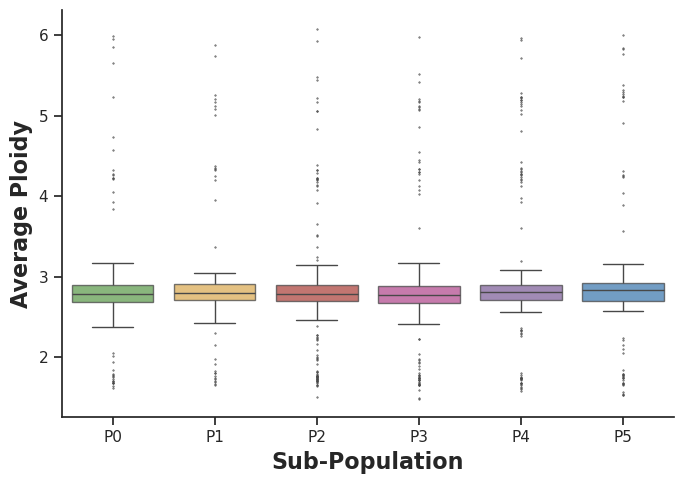

In [43]:
sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)
ax = sns.boxplot(
    data=adata.obs,
    x='pop',
    y='ploidy',
    palette=pal,
    fliersize=0.5
)
# ax.set_xscale('log')
for patch in ax.patches:
    patch.set_alpha(0.75) 
# plt.ylim(0,4)
plt.ylabel('Average Ploidy', fontweight='bold', fontsize=16)
plt.xlabel('Sub-Population', fontweight='bold', fontsize=16)

new_labels = ['P0', 'P1', 'P2', 'P3', 'P4', 'P5'] 
ax.set_xticklabels(new_labels)

plt.tight_layout()
# f.savefig('figures/SNPs_per_cell.png', dpi=600, bbox_inches='tight')

<Axes: xlabel='ploidy', ylabel='Count'>

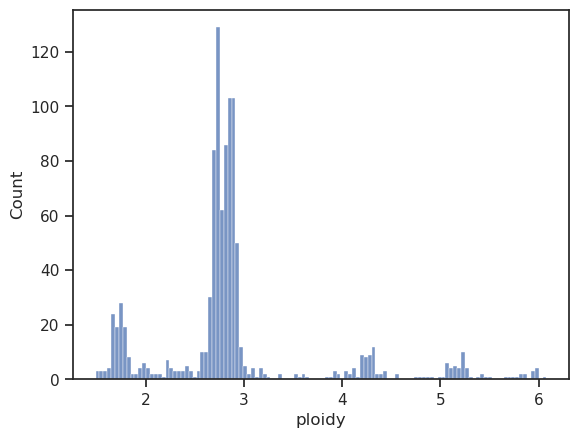

In [122]:
sns.histplot(adata.obs,
             x='ploidy',
            )

In [123]:
adata.obs['ploidy'].median()

np.float64(2.799147442326981)

In [129]:
adata.obs[adata.obs['ploidy']<2.5].shape[0]

165

In [144]:
count = adata.obs[(adata.obs['ploidy']>=2.5) & (adata.obs['ploidy']<3.5)].shape[0]
av_ploidy = adata.obs[(adata.obs['ploidy']>=2.5) & (adata.obs['ploidy']<3.5)]['ploidy'].mean()
print(f"{(count/1000)*100}% of cells have avg ploidy: {av_ploidy}")

70.3% of cells have avg ploidy: 2.80685941180583


In [142]:
count = adata.obs[(adata.obs['ploidy']>=3.5) & (adata.obs['ploidy']<4.5)].shape[0]
av_ploidy = adata.obs[(adata.obs['ploidy']>=3.5) & (adata.obs['ploidy']<4.5)]['ploidy'].mean()
print(f"{(count/1000)*100}% of cells have avg ploidy: {av_ploidy}")

6.800000000000001% of cells have avg ploidy: 4.1572511652604875


In [143]:
count = adata.obs[adata.obs['ploidy']>=4.5].shape[0]
av_ploidy = adata.obs[adata.obs['ploidy']>=4.5]['ploidy'].mean()
print(f"{(count/1000)*100}% of cells have avg ploidy: {av_ploidy}")

6.4% of cells have avg ploidy: 5.323243167001003


### Comparison with K562 ref

In [212]:
cnv = pd.read_csv('AneuFinder_output/result.csv', index_col=0)
cnv.rename(columns={'seqnames':'Chromosome','start':'Start','end':'End'}, inplace=True)
cnv

,Chromosome,Start,End,GTGAGACTAGGATGGTCACTACTCAGGACATCAAGGACATCGTCA,CGCTAGTTAGGAGTCTGCTAACTCGGAACTGTAAGGGTGACTCTA,GTAATGCCAGGACGACAAGAACTCACAGTAGCAAGGGTGACTCTA,ACCTCGTAAGGATACAGCAGACTCGGAACTGTAAGGCGGTTGATA,CGGTAGAAAGGAACCTTCAGACTCTCTGCTTGAAGGTTGACCACA,ATACGACCAGGAAACGATGGACTCCGAACTTGAAGGGTGACTCTA,CAACCAACAGGAGTCTGCTAACTCAGAATGCCAAGGGTGACTCTA,...,GGTCATTGAGGACTGCTCAAACTCGGAACTGTAAGGTTGATGGCA,ATATGCGGAGGACACCTTGAACTCTGCTATGGAAGGCGACCTATA,ATCGACAGAGGAAACTGCTCACTCTCCAGTCTAAGGCGGTTGATA,CGGTAGAAAGGAAAGGTGACACTCTGCTATGGAAGGTTGGATGCA,CGGTAGAAAGGATACAGCAGACTCTACAACCGAAGGTGGTCTCAA,TACCACAGAGGACTTCAGCAACTCAGACGAACAAGGAGATACCGA,CGGTAGAAAGGAAACGATGGACTCAGAATGCCAAGGAGATACCGA,GTGAGACTAGGAAACTGCTCACTCCACCATCTAAGGTTGGATGCA,AAGGCTTGAGGACGACAAGAACTCCACCATCTAAGGCGGTAAGTA,GGTCATTGAGGAAACGATGGACTCTCCAGTCTAAGGGATGGTCTA
1,chr1,1,3000000,1,2,1,2,1,3,2,...,1,2,2,2,2,1,2,2,2,2
2,chr1,3000001,4000000,1,2,1,2,1,3,2,...,1,2,2,2,2,1,2,2,2,2
3,chr1,4000001,5000000,2,2,2,2,3,3,2,...,2,2,4,2,2,2,2,3,3,2
4,chr1,5000001,6000000,2,2,2,2,3,3,2,...,2,2,4,2,2,2,4,3,3,2
5,chr1,6000001,7000000,2,2,2,2,3,3,2,...,2,2,4,2,2,2,4,3,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1990,chrX,153000001,156000000,1,2,1,2,1,2,3,...,1,2,2,1,2,1,2,2,1,2
1991,chrY,1,10000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1992,chrY,10000001,12000000,0,0,0,0,0,0,2,...,1,0,0,1,0,0,0,0,0,0
1993,chrY,12000001,57000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [213]:
ref = pd.read_csv('K562_ref_ploidy_hg38.bed', sep='\t', header=None)
ref.columns = ['Chromosome', 'Start', 'End', 'Ploidy']
ref

,Chromosome,Start,End,Ploidy
0,chr1,10000,54799327,4
1,chr1,54799327,106777378,3
2,chr1,106777378,121743636,4
3,chr1,143822875,162380210,3
4,chr1,162380210,248744909,4
...,...,...,...,...
56,chr19,60000,58607616,3
57,chr20,79359,26338933,2
58,chr20,30184893,64334167,3
59,chr21,24127687,46699983,4


In [214]:
ref['Ploidy'].mean()

np.float64(2.8524590163934427)

In [215]:
# Create PyRanges for bins and reference
bins_pr = pr.PyRanges(cnv[['Chromosome', 'Start', 'End']])
ref_pr = pr.PyRanges(ref[['Chromosome', 'Start', 'End', 'Ploidy']])

In [216]:
# Map each bin to overlapping reference region
joined = bins_pr.join(ref_pr)

# Convert back to DataFrame and merge with original CNV values
joined_df = joined.as_df()
joined_df

,Chromosome,Start,End,Start_b,End_b,Ploidy
0,chr1,1,3000000,10000,54799327,4
1,chr1,3000001,4000000,10000,54799327,4
2,chr1,4000001,5000000,10000,54799327,4
3,chr1,5000001,6000000,10000,54799327,4
4,chr1,6000001,7000000,10000,54799327,4
...,...,...,...,...,...,...
1931,chrX,149000001,150000000,10000,156030895,2
1932,chrX,150000001,151000000,10000,156030895,2
1933,chrX,151000001,152000000,10000,156030895,2
1934,chrX,152000001,153000000,10000,156030895,2


In [217]:
cnv = cnv.merge(
    joined_df[['Chromosome', 'Start', 'End', 'Ploidy']],
    on=['Chromosome', 'Start', 'End'],
    how='left'  # important!
)
cnv.rename(columns={'Ploidy':'K562_ref'}, inplace=True)
cnv = cnv.fillna(3)
cnv['K562_ref'] = cnv['K562_ref'].astype(int)
cnv

,Chromosome,Start,End,GTGAGACTAGGATGGTCACTACTCAGGACATCAAGGACATCGTCA,CGCTAGTTAGGAGTCTGCTAACTCGGAACTGTAAGGGTGACTCTA,GTAATGCCAGGACGACAAGAACTCACAGTAGCAAGGGTGACTCTA,ACCTCGTAAGGATACAGCAGACTCGGAACTGTAAGGCGGTTGATA,CGGTAGAAAGGAACCTTCAGACTCTCTGCTTGAAGGTTGACCACA,ATACGACCAGGAAACGATGGACTCCGAACTTGAAGGGTGACTCTA,CAACCAACAGGAGTCTGCTAACTCAGAATGCCAAGGGTGACTCTA,...,ATATGCGGAGGACACCTTGAACTCTGCTATGGAAGGCGACCTATA,ATCGACAGAGGAAACTGCTCACTCTCCAGTCTAAGGCGGTTGATA,CGGTAGAAAGGAAAGGTGACACTCTGCTATGGAAGGTTGGATGCA,CGGTAGAAAGGATACAGCAGACTCTACAACCGAAGGTGGTCTCAA,TACCACAGAGGACTTCAGCAACTCAGACGAACAAGGAGATACCGA,CGGTAGAAAGGAAACGATGGACTCAGAATGCCAAGGAGATACCGA,GTGAGACTAGGAAACTGCTCACTCCACCATCTAAGGTTGGATGCA,AAGGCTTGAGGACGACAAGAACTCCACCATCTAAGGCGGTAAGTA,GGTCATTGAGGAAACGATGGACTCTCCAGTCTAAGGGATGGTCTA,K562_ref
0,chr1,1,3000000,1,2,1,2,1,3,2,...,2,2,2,2,1,2,2,2,2,4
1,chr1,3000001,4000000,1,2,1,2,1,3,2,...,2,2,2,2,1,2,2,2,2,4
2,chr1,4000001,5000000,2,2,2,2,3,3,2,...,2,4,2,2,2,2,3,3,2,4
3,chr1,5000001,6000000,2,2,2,2,3,3,2,...,2,4,2,2,2,4,3,3,2,4
4,chr1,6000001,7000000,2,2,2,2,3,3,2,...,2,4,2,2,2,4,3,3,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020,chrX,153000001,156000000,1,2,1,2,1,2,3,...,2,2,1,2,1,2,2,1,2,2
2021,chrY,1,10000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
2022,chrY,10000001,12000000,0,0,0,0,0,0,2,...,0,0,1,0,0,0,0,0,0,3
2023,chrY,12000001,57000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [222]:
# Identify cell columns (excluding coord + reference)
non_cell_cols = ['Chromosome', 'Start', 'End', 'K562_ref']
cell_cols = [col for col in cnv.columns if col not in non_cell_cols]

# Create matrix for cells and reference
cell_matrix = cnv[cell_cols]
ref_vector = cnv['K562_ref']


In [223]:
# Mean absolute difference per cell
mean_abs_diff = cell_matrix.sub(ref_vector, axis=0).abs().mean()

# Pearson correlation per cell
pearson_corr = cell_matrix.corrwith(ref_vector)

In [226]:
summary_df = pd.DataFrame({
    'Avg_Ploidy': adata.obs['ploidy'],
    'MeanAbsDiff': mean_abs_diff.values,
    'PearsonCorrelation': pearson_corr.values
})

In [227]:
summary_df

,Avg_Ploidy,MeanAbsDiff,PearsonCorrelation
GTGAGACTAGGATGGTCACTACTCAGGACATCAAGGACATCGTCA,1.733701,1.305185,0.654552
CGCTAGTTAGGAGTCTGCTAACTCGGAACTGTAAGGGTGACTCTA,2.820461,0.713086,0.487912
GTAATGCCAGGACGACAAGAACTCACAGTAGCAAGGGTGACTCTA,1.751755,1.286914,0.647618
ACCTCGTAAGGATACAGCAGACTCGGAACTGTAAGGCGGTTGATA,2.905717,0.210864,0.711136
CGGTAGAAAGGAACCTTCAGACTCTCTGCTTGAAGGTTGACCACA,2.718656,0.367901,0.647837
...,...,...,...
TACCACAGAGGACTTCAGCAACTCAGACGAACAAGGAGATACCGA,1.830993,1.213333,0.663381
CGGTAGAAAGGAAACGATGGACTCAGAATGCCAAGGAGATACCGA,2.883149,0.233580,0.692488
GTGAGACTAGGAAACTGCTCACTCCACCATCTAAGGTTGGATGCA,2.795386,0.372840,0.652743
AAGGCTTGAGGACGACAAGAACTCCACCATCTAAGGCGGTAAGTA,3.004012,0.443951,0.689641


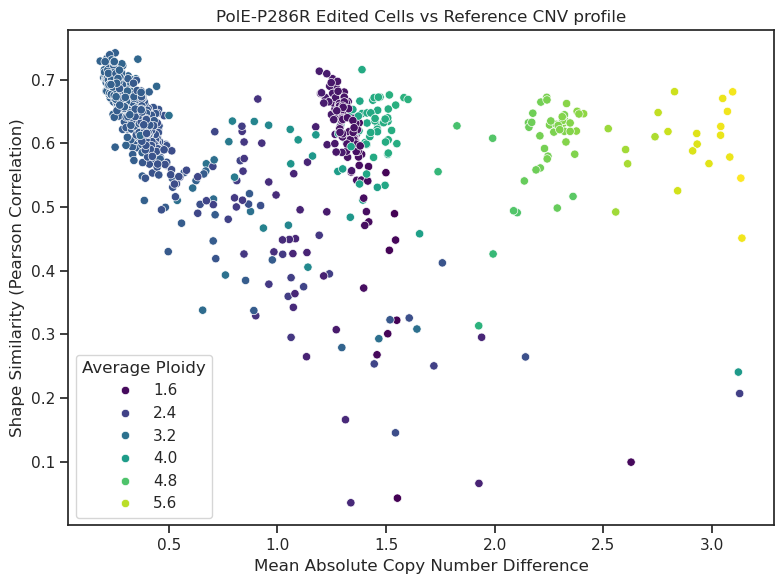

In [235]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=summary_df,
                x='MeanAbsDiff',
                y='PearsonCorrelation', 
                hue='Avg_Ploidy',
                palette='viridis'
               )
plt.xlabel('Mean Absolute Copy Number Difference')
plt.ylabel('Shape Similarity (Pearson Correlation)')
plt.title('PolE-P286R Edited Cells vs Reference CNV profile')
plt.legend(title='Average Ploidy')
plt.tight_layout()
plt.show()

In [240]:
mean_rho = pearson_corr.mean()
std_rho = pearson_corr.std()
print(f'mean rho = {mean_rho:.2f}')
print(f'standard deviation = {std_rho:.2f}')

mean rho = 0.62
standard deviation = 0.09


In [258]:
## Generate permutation based null
def shuffled_corr(ref_vector, cell_matrix, n_permutations=1000, seed=42):
    np.random.seed(seed)
    shuffled_corrs = []
    for _ in tqdm(range(n_permutations)):
        shuffled_ref = ref_vector.sample(frac=1, replace=False).reset_index(drop=True)
        cell_corrs = cell_matrix.corrwith(shuffled_ref)
        shuffled_corrs.append(cell_corrs.mean())
    return np.array(shuffled_corrs)

In [259]:
mean_rho = pearson_corr.mean()
null_corrs = shuffled_corr(ref_vector, cell_matrix, n_permutations=1000)

# One-sided p-value: are real correlations significantly higher than null?
empirical_p = np.mean(null_corrs >= mean_rho)

100%|██████████| 1000/1000 [15:18<00:00,  1.09it/s]


In [260]:
empirical_p

np.float64(0.0)

### Neighbor Joining tree from CNV data

**TODO**: outgroup rooting with "normal K562" CNV profile

In [266]:
tree_matrix = cell_matrix
tree_matrix['K562'] = ref_vector

/loc/scratch/25689862/ipykernel_12588/4058833123.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree_matrix['K562'] = ref_vector


In [267]:
## Pearson Correlation
corr_matrix = tree_matrix.corr()
distance_matrix = 1 - corr_matrix
distance_matrix = ssd.squareform(distance_matrix)

In [269]:
dm = DistanceMatrix(distance_matrix, ids=tree_matrix.columns.to_list())
tree = nj(dm)
tree = nni(tree, dm)

tree = tree.root_by_outgroup(['K562'])
tree.write('results/cnv_sc_test.newick')

'results/cnv_sc_test.newick'

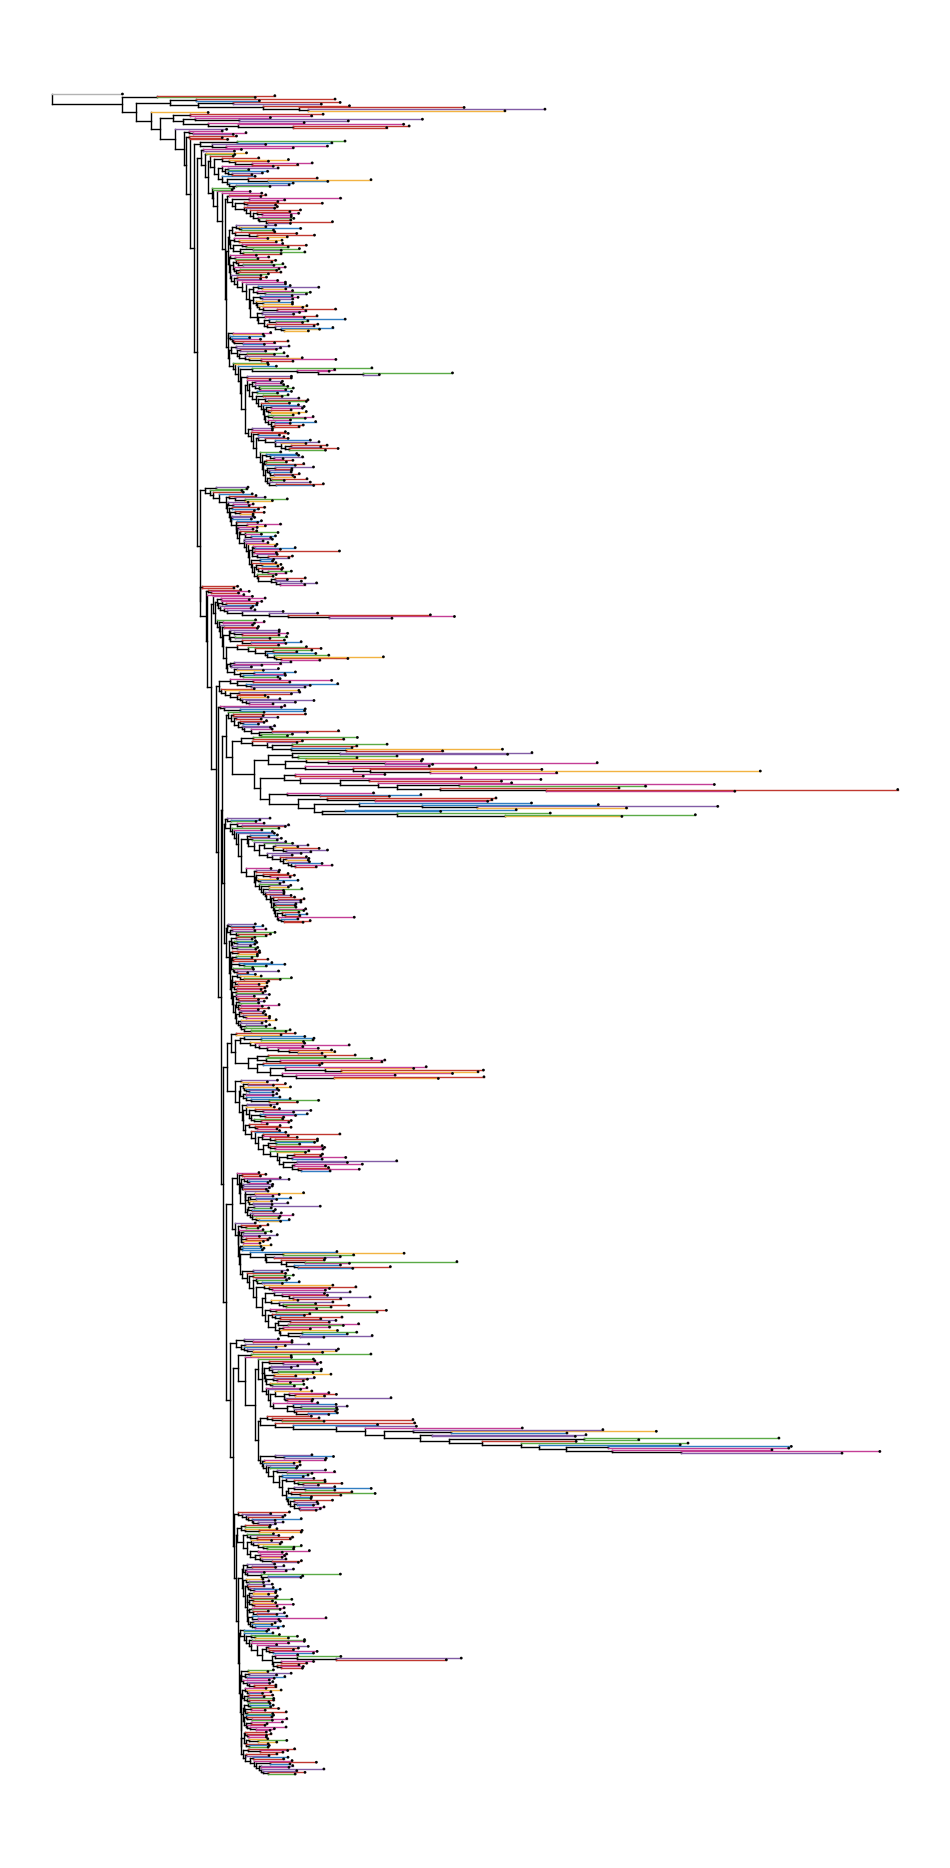

In [270]:
newickPath='results/cnv_sc_test.newick'
tree = bt.loadNewick(newickPath)

tips = [k for k in tree.Objects if k.is_leaf()]
tip_names = [k.name for k in tips]

fig,ax = plt.subplots(figsize=(12,24))

# x_attr=lambda k: k.absoluteTime
c_func=lambda n: pal[adata.obs.loc[n.name]['pop']] if n.is_leaf() else 'black'

tree.plotTree(ax, width=1, colour=c_func)
tree.plotPoints(ax,size=2,colour='black',zorder=100) ## tips

target_func=lambda k: k.is_leaf() ## which branches will be annotated
text_func=lambda k: k.name
text_x_attr=lambda k: k.x+0.01
kwargs={'va':'center','ha':'left','size': 8} ## kwargs for text

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

fig.savefig('figures/cnv_sc_test_tree_c.png', dpi=600)

### CNV Tree with bootstrapping

In [274]:
tree_matrix.shape[0]

2025

In [275]:
n_bootstraps = 1000
bootstrap_tree_list = dendropy.TreeList()

for i in tqdm(range(n_bootstraps)):
    
    feature_idx = np.random.choice(np.arange(tree_matrix.shape[0]), size=tree_matrix.shape[0], replace=True)
    sampled = tree_matrix.iloc[feature_idx]
    sampled_X = sampled.values
    
    corr_matrix = tree_matrix.corr()
    distance_matrix = 1 - corr_matrix
    distance_matrix = ssd.squareform(distance_matrix)

    # Build NJ tree
    dm = DistanceMatrix(distance_matrix, ids=tree_matrix.columns.to_list())
    tree = nj(dm)
    # tree = gme(dm)
    # tree = bme(dm)
    # tree = nni(tree, dm)
    
    tree = tree.root_by_outgroup(['K562'])
    
    handle = StringIO()
    tree.write(handle)
    newick_str = handle.getvalue()
    t = dendropy.Tree.get(data=newick_str, schema="newick")
    t.is_rooted = True
    bootstrap_tree_list.append(t)

100%|██████████| 1000/1000 [1:14:40<00:00,  4.48s/it]


In [276]:
bootstrap_tree_list.write(
    path="results/sc_cnv_bootstrap_trees.tre",
    schema="newick",
    suppress_rooting=False
)

# Final Consensus tree

In [ ]:
## Combine bootstrap lists


In [115]:
!sumtrees --decimals=0 -s mcct --percentages --output-tree-filepath=results/sc_bootstrap_consensus.tre --force-rooted results/sc_bootstrap_trees.tre

/==========================================================================\
|                                 SumTrees                                 |
|                     Phylogenetic Tree Summarization                      |
|                              Version 5.0.1                               |
|                   By Jeet Sukumaran and Mark T. Holder                   |
|                         Using: DendroPy 5.0.1 ()                         |
+--------------------------------------------------------------------------+
|                                 Citation                                 |
|                                 ~~~~~~~~                                 |
| If any stage of your work or analyses relies on code or programs from    |
| this library, either directly or indirectly (e.g., through usage of your |
| own or third-party programs, pipelines, or toolkits which use, rely on,  |
| incorporate, or are otherwise primarily derivative of code/programs in   |

In [116]:
# Load the consensus tree
tree = dendropy.Tree.get(path="results/sc_bootstrap_consensus.tre", schema="nexus")

# Write the resolved tree to a new file
tree.write(path="results/sc_bootstrap_consensus.newick", schema="newick")

In [117]:
newickPath='results/sc_bootstrap_consensus.newick'
tree = bt.loadNewick(newickPath)

tips = [k for k in tree.Objects if k.is_leaf()]
tip_names = [k.name for k in tips]

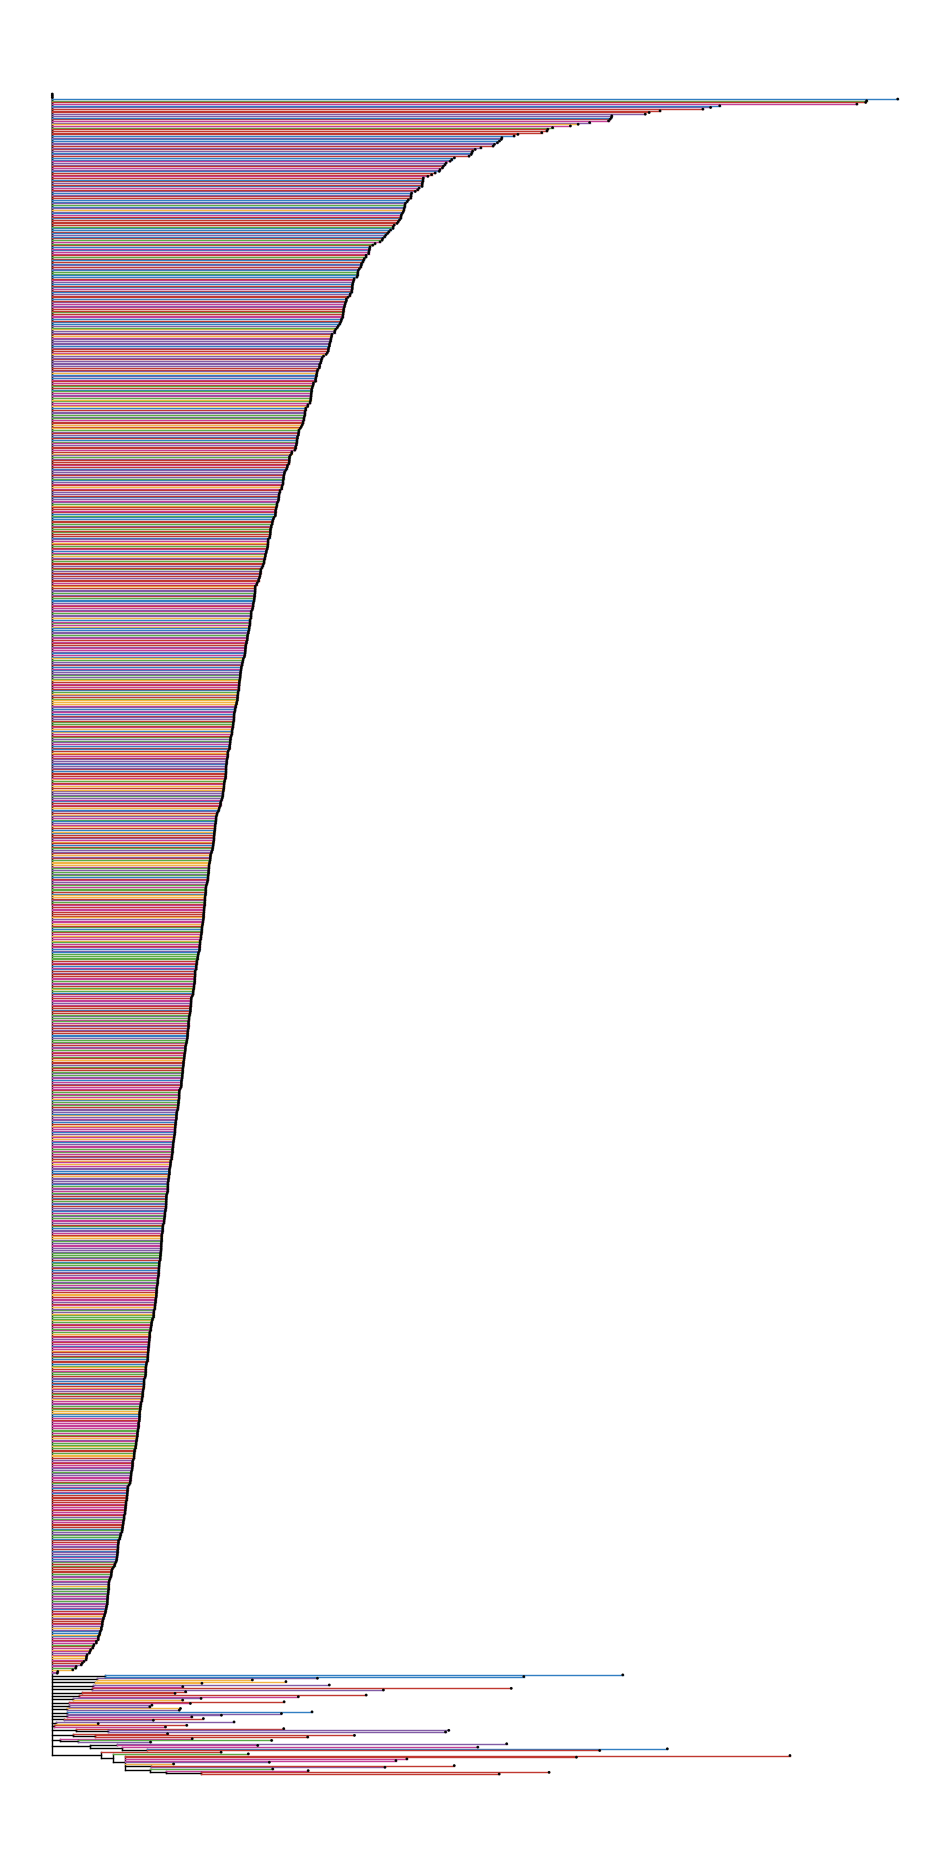

In [ ]:
fig,ax = plt.subplots(figsize=(12,24))

# x_attr=lambda k: k.absoluteTime
c_func=lambda n: pal[adata.obs.loc[n.name]['pop']] if n.is_leaf() and n.name != 'K562' else 'black'

tree.plotTree(ax, width=1, colour=c_func)
tree.plotPoints(ax,size=2,colour='black',zorder=100) ## tips

target_func=lambda k: k.is_leaf() ## which branches will be annotated
text_func=lambda k: k.name
text_x_attr=lambda k: k.x+0.01
kwargs={'va':'center','ha':'left','size': 8} ## kwargs for text

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

fig.savefig('figures/sc_bs_tree.png', dpi=600)